In [2]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import importlib as imp
import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help

imp.reload(fig_help)

import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True
latex_engine = 'pdflatex'
latex_elements = {
    'extrapackages': r'\usepackage{physics}',
    'extrapackages': r'\usepackage{amsmath}'
}
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


USE_SYMMETRIES = True
BOUNDARY_COND = 'PBC'

base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'
print(base_dir)

/Users/rafal.swietek/Projects/QHamSolver/XYZ/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/symmetries/PBC/


In [3]:
import decimal

def format_number(num):
    try:
        dec = decimal.Decimal(num)
    except:
        return 'bad'
    tup = dec.as_tuple()
    delta = len(tup.digits) + tup.exponent
    digits = ''.join(str(d) for d in tup.digits)
    if delta <= 0:
        zeros = abs(tup.exponent) - len(tup.digits)
        val = '0.' + ('0'*zeros) + digits
    else:
        val = digits[:delta] + ('0'*tup.exponent) + '.' + digits[delta:]
    val = val.rstrip('0')
    if val[-1] == '.':
        val = val[:-1]
    if tup.sign:
        return '-' + val
    return val

def order_of_magnitude(a_value):
    a_value = np.round(a_value, 6)
    if a_value - int(a_value) != 0:
        a_str = format_number(f'{a_value}')
        a_str = a_str.split(".")[1]
        return len(a_str)
    else:
        return 0

In [4]:
def info_base(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0):
    arr = [J1, J2, delta1, delta2, eta1, eta2, hx, hz]
    names = ['J1', 'J2','d1', 'd2', 'e1', 'e2', 'hx', 'hz']
    info = "_L=%d"%L
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info_sym(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, k=0, p=1, zx=1, zz=1, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    if BOUNDARY_COND == 'PBC':                          info += ",k=%d"%k
    if BOUNDARY_COND == 'OBC' or (k==0 or k==L/2):     info += ",p=%d"%p
    if hz == 0 and not edge and (L % 2 == 0 or hx != 0):info += ",zx=%d"%zx
    if hx == 0:                                         info += ",zz=%d"%zz
    info += ",edge=%d"%edge
    return info

def info_dis(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, w=0, pb=0, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    n = order_of_magnitude(w)
    info +=  str(",w={:.%df}"%n).format(round(w, n))
    info += ",edge=%d"%edge
    info += ",pb=%d"%pb
    return info

In [5]:
parity_sectors = [-1, 1]
def get_sectors(L, hx, hz):
    translation_real_sectors = [0, L // 2] if BOUNDARY_COND == 'PBC' and L % 2 == 0 else [0]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_X_sectors = [-1, 1] if hz == 0 else [1]
    spin_flip_Z_sectors = [-1, 1] if hx == 0 and (L % 2 == 0 or hz != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors

In [6]:

def page_result(L_a, L_b):
    d_a = 2**L_a
    d_b = 2**L_b
    return digamma(d_a * d_b + 1) - digamma(d_b + 1) - (d_a - 1) / (2*d_b)

In [2]:
for x in range(100):
    print(x, x*(x+1)/2, (x*(x+1)/2)%2)

0 0.0 0.0
1 1.0 1.0
2 3.0 1.0
3 6.0 0.0
4 10.0 0.0
5 15.0 1.0
6 21.0 1.0
7 28.0 0.0
8 36.0 0.0
9 45.0 1.0
10 55.0 1.0
11 66.0 0.0
12 78.0 0.0
13 91.0 1.0
14 105.0 1.0
15 120.0 0.0
16 136.0 0.0
17 153.0 1.0
18 171.0 1.0
19 190.0 0.0
20 210.0 0.0
21 231.0 1.0
22 253.0 1.0
23 276.0 0.0
24 300.0 0.0
25 325.0 1.0
26 351.0 1.0
27 378.0 0.0
28 406.0 0.0
29 435.0 1.0
30 465.0 1.0
31 496.0 0.0
32 528.0 0.0
33 561.0 1.0
34 595.0 1.0
35 630.0 0.0
36 666.0 0.0
37 703.0 1.0
38 741.0 1.0
39 780.0 0.0
40 820.0 0.0
41 861.0 1.0
42 903.0 1.0
43 946.0 0.0
44 990.0 0.0
45 1035.0 1.0
46 1081.0 1.0
47 1128.0 0.0
48 1176.0 0.0
49 1225.0 1.0
50 1275.0 1.0
51 1326.0 0.0
52 1378.0 0.0
53 1431.0 1.0
54 1485.0 1.0
55 1540.0 0.0
56 1596.0 0.0
57 1653.0 1.0
58 1711.0 1.0
59 1770.0 0.0
60 1830.0 0.0
61 1891.0 1.0
62 1953.0 1.0
63 2016.0 0.0
64 2080.0 0.0
65 2145.0 1.0
66 2211.0 1.0
67 2278.0 0.0
68 2346.0 0.0
69 2415.0 1.0
70 2485.0 1.0
71 2556.0 0.0
72 2628.0 0.0
73 2701.0 1.0
74 2775.0 1.0
75 2850.0 0.0
76 2926.0

In [75]:
L = 21

def momentum(n, Lmax = L+1):
    K = 0
    for ii, x in enumerate(n):
        if x != 0 and ii < Lmax:
            K += ii
    return K
def num_of_particles(n):
    N = 0
    for ii, x in enumerate(n):
        if x != 0:
            N += 1
    return N

    
permut = [L//2 - x for x in range(0,L//2+1)] + [L//2 - x + L for x in range(L//2 + 2, L)]
#permut = [(x + L//2)%(L) for x in range(0,L)]

print(permut)
for real in range(50):
    state = np.array([random.randint(0, 1) for _ in range(L)])

    new_state = state[permut]
    K1 =  momentum(state)
    K2 =  momentum(new_state)
    #if K1 == K2:
    print(real, state, "\t -> \t", new_state, "\t", num_of_particles(state) ,"\t dK=", (K2-K1)/(L//2), "pi")

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 19, 18, 17, 16, 15, 14, 13, 12, 11]
0 [0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1] 	 -> 	 [1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1] 	 10 	 dK= -1.2 pi
1 [0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0] 	 -> 	 [0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0] 	 8 	 dK= 0.6 pi
2 [1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1] 	 -> 	 [1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1] 	 13 	 dK= -0.8 pi
3 [1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1] 	 -> 	 [1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0] 	 10 	 dK= -0.8 pi
4 [0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1] 	 -> 	 [0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1] 	 9 	 dK= -0.4 pi
5 [0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0] 	 -> 	 [1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1] 	 12 	 dK= 0.0 pi
6 [1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1] 	 -> 	 [1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0] 	 13 	 dK= -0.8 pi
7 [1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1] 	 -> 	 [0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1] 	 9 	 dK= -0.6 pi
8 [0 1 0 1 1 1 0 1 0 0

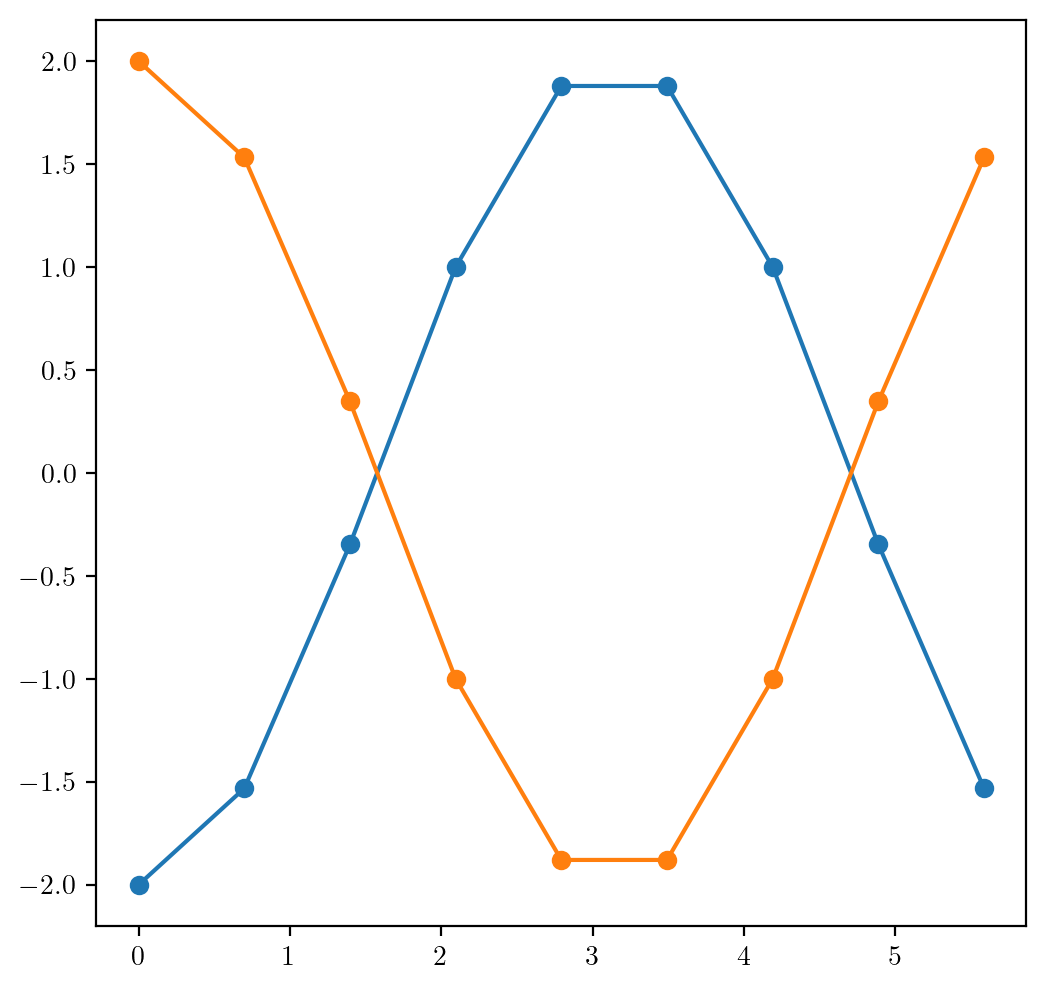

In [12]:
L=9

ks = np.array([2*np.pi*m / L for m in range(L)])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)

axis.scatter(ks, -2*np.cos(ks))
axis.plot(ks, -2*np.cos(-ks))
axis.scatter(ks, -2*np.cos(ks + np.pi))
axis.plot(ks, -2*np.cos(-ks - np.pi))

# $$H=J\sum_\ell(1-\eta)S^x_\ell S^x_{\ell+1} + (1+\eta)S^y_\ell S^y_{\ell+1} + \Delta S^z_\ell S^z_{\ell+1}+E_0$$
# $$J^xJ^y\pm J^xJ^z\pm J^yJ^z=0\qquad\rightarrow\qquad 1-\eta^2\pm\Delta(1-\eta)\pm\Delta(1+\eta)=0$$
# $$\Delta=\pm\frac{1}{2}(1-\eta^2)\qquad \vee \qquad \Delta=\pm\frac{1}{2\eta}(1-\eta^2)$$
# $$E_0=L\cdot\frac{3+\eta^2}{8}$$

# PARAMETER SWEEP

## MATRIX ELEMENTS -- RIGOL ET.AL.

In [46]:
eta=0.2
print((1-eta**2)/2, (1-eta**2)/(2*eta))

0.48 2.4


../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.3,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.28,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.26,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.24,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.22,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.2,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.18,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.16,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=1

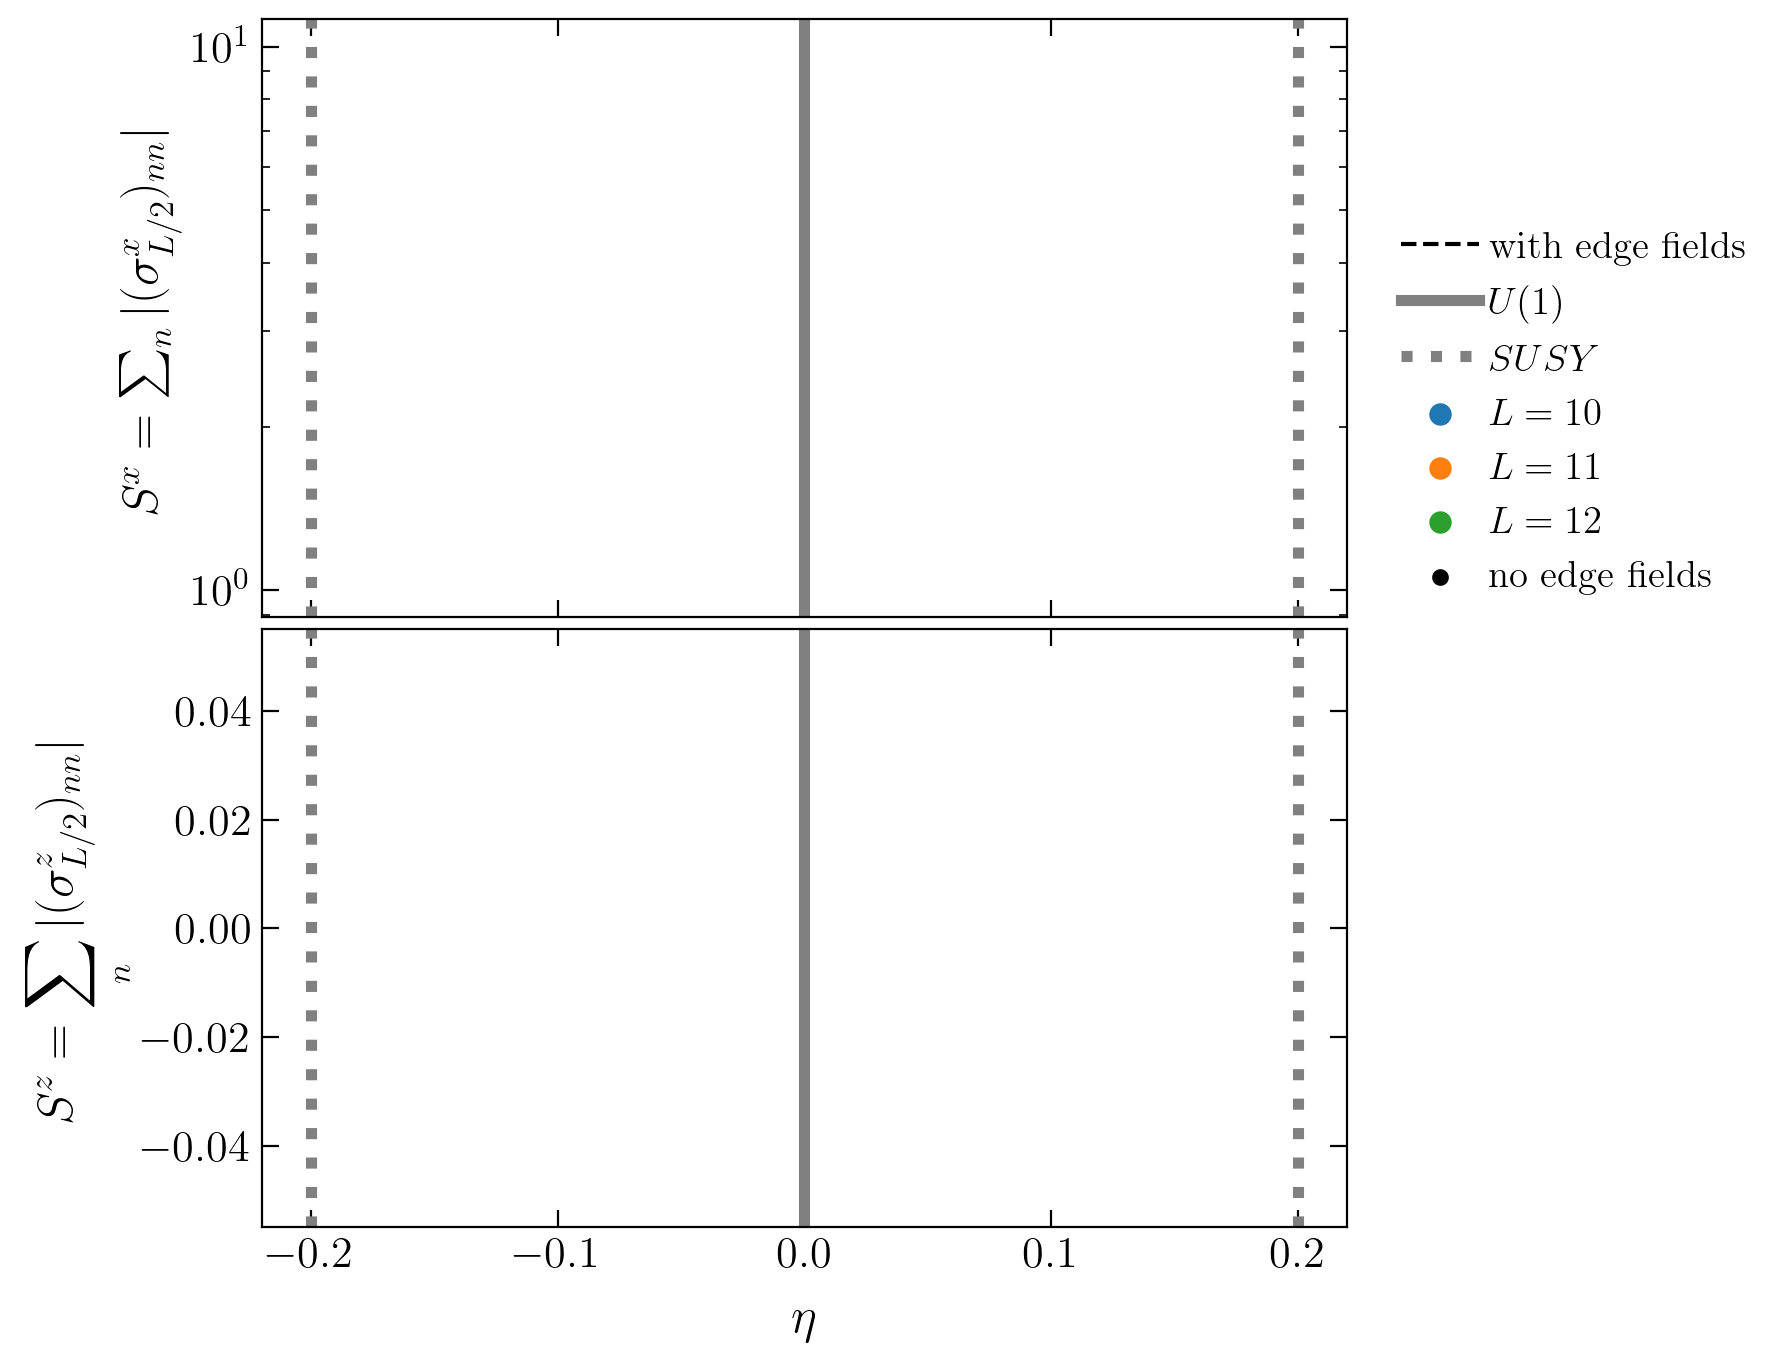

In [41]:
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(7,8), dpi = 200, sharex=True)

L=12
J1=1.0
d1=0.48
e1=0.4

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0
w=0
pb=0
edge=1

etas = np.arange(start=-0.3, step=0.02, stop=0.3)

colors_ls_cyc = itertools.cycle(colors_ls)
for ii, L in enumerate([10, 11, 12]):
    col = next(colors_ls_cyc)
    for edge in [0, 1]:
        sigX = []
        sigZ = []
        for e1 in etas:
            filename = base_dir + "DiagMatElem/" + info_dis(L, J1, J2, d1, d2, e1, e2, hx, hz, w, pb, edge) + "_jobid=0.hdf5"
            if exists(filename):
                with h5py.File(filename, "r") as file:
                        energies = np.array(file.get('energies')).flatten()
                        sigX.append(np.sum(np.abs(np.array(file.get('sigmaX_L_2')).view('complex').flatten())))
                        sigZ.append(np.sum(np.abs(np.array(file.get('sigmaZ_L_2')).view('complex').flatten())))
            else: 
                print(filename)
                sigX.append(np.nan)
                sigZ.append(np.nan)
        if edge == 0: 
             axis[0].scatter(etas, sigX, marker='o', color=col, s=50, label=r"$L=%d$"%L)
             axis[1].scatter(etas, sigZ, marker='o', color=col, s=50)
        else:
             axis[0].plot(etas, sigX, color=col, ls='--')
             axis[1].plot(etas, sigZ, color=col, ls='--')


axis[0].scatter(np.nan, np.nan, marker='o', color='black', s=25, label="no edge fields")
axis[0].plot(np.nan, np.nan, ls='--', color='black', label="with edge fields")

for ax in axis:
     ax.axvline(x=0, ls='-', lw=4, c='gray', label=r"$U(1)$")
     ax.axvline(x=0.2, ls=':', lw=4, c='gray', label=r"$SUSY$")
     ax.axvline(x=-0.2, ls=':', lw=4, c='gray')
fig_help.set_plot_elements(axis[0], ylabel=r"$S^x=\sum_n|(\sigma^x_{L/2})_{nn}|$", xlabel=r"$\eta$", font_size=16, set_legend=True, yscale='log')
axis[0].legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=14, handletextpad=0.25, handlelength = 2., bbox_to_anchor=(1.4,-0.02))

fig_help.set_plot_elements(axis[1], ylabel=r"$$S^z=\sum_n|(\sigma^z_{L/2})_{nn}|$$", xlabel=r"$\eta$", font_size=16, set_legend=False, yscale='log')

axis[1].set_yscale('linear')
fig.subplots_adjust(wspace = 0.02, hspace=0.02)

plt.savefig("diagonal_matrix_elements.pdf", bbox_inches = 'tight', pad_inches=0.02)

## DEGENERACY

2192 32768
15 -0.75 0.0
2192 32768
15 -0.375 0.00592041015625
2192 32768
15 0.2 0.0
2192 32768
15 0.2 0.0
8230 65536
16 -0.75 0.0039215087890625
8230 65536
16 -0.375 0.003753662109375
8230 65536
16 0.2 0.0
8230 65536
16 0.2 0.0
7712 131072
17 -0.75 0.0
7712 131072
17 -0.375 0.006988525390625
7712 131072
17 0.2 0.0
7712 131072
17 0.2 0.0
29144 262144
18 -0.75 0.00495147705078125
29144 262144
18 -0.375 0.0049285888671875
29144 262144
18 0.2 0.0
29144 262144
18 0.2 0.0
27596 524288
19 -0.75 0.0
27596 524288
19 -0.375 0.007724761962890625
27596 524288
19 0.2 0.0
27596 524288
19 0.2 0.0
104968 1048576
20 -0.75 0.0065174102783203125
104968 1048576
20 -0.375 0.006499290466308594
104968 1048576
20 0.2 0.0
104968 1048576
20 0.2 0.0
99880 2097152
21 -0.75 0.0
99880 2097152
21 -0.375 0.0081634521484375
99880 2097152
21 0.2 0.0
99880 2097152
21 0.2 0.0
381304 4194304
22 -0.75 0.007803201675415039
381304 4194304
22 -0.375 0.007798671722412109
381304 4194304
22 0.2 0.0
381304 4194304
22 0.2 0.0
../r

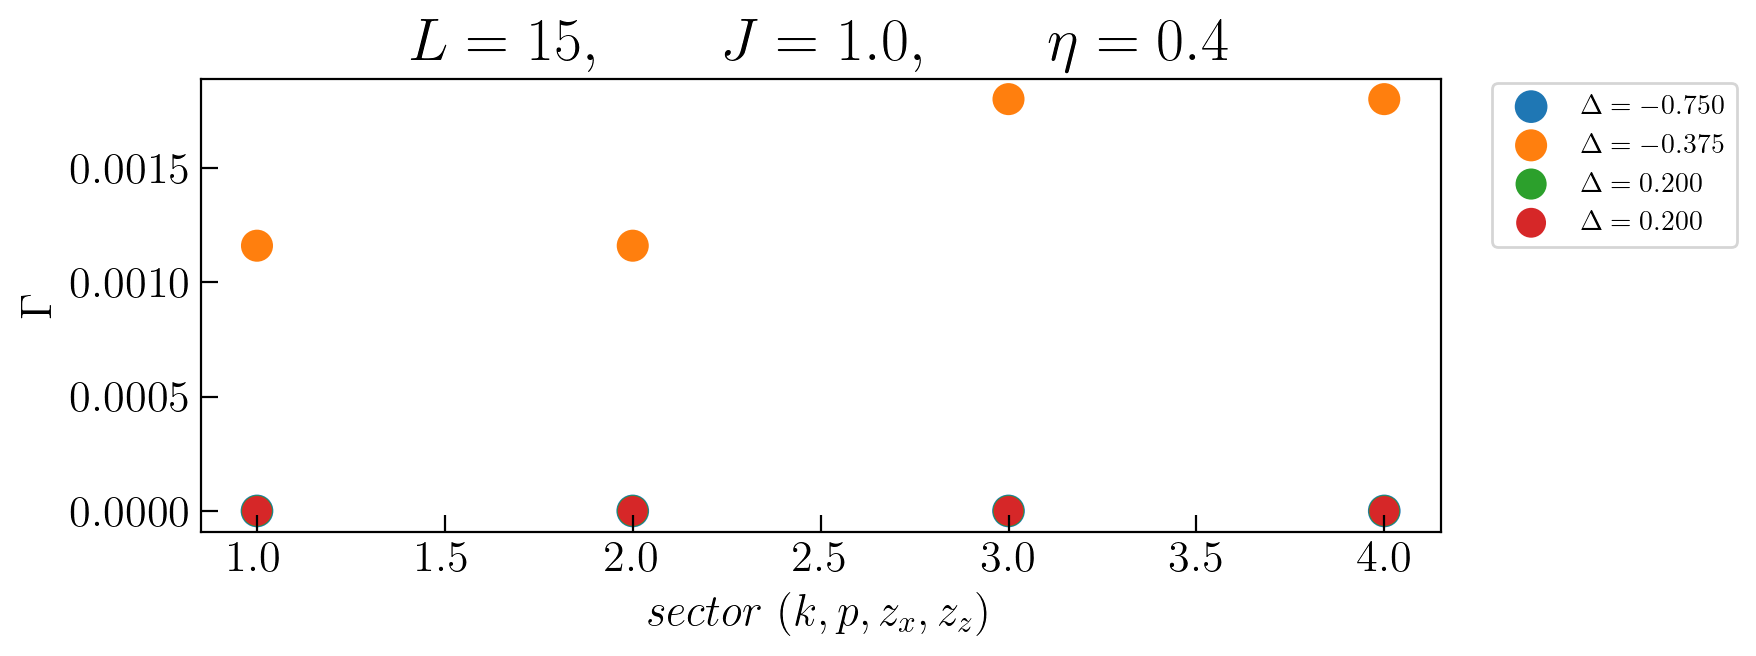

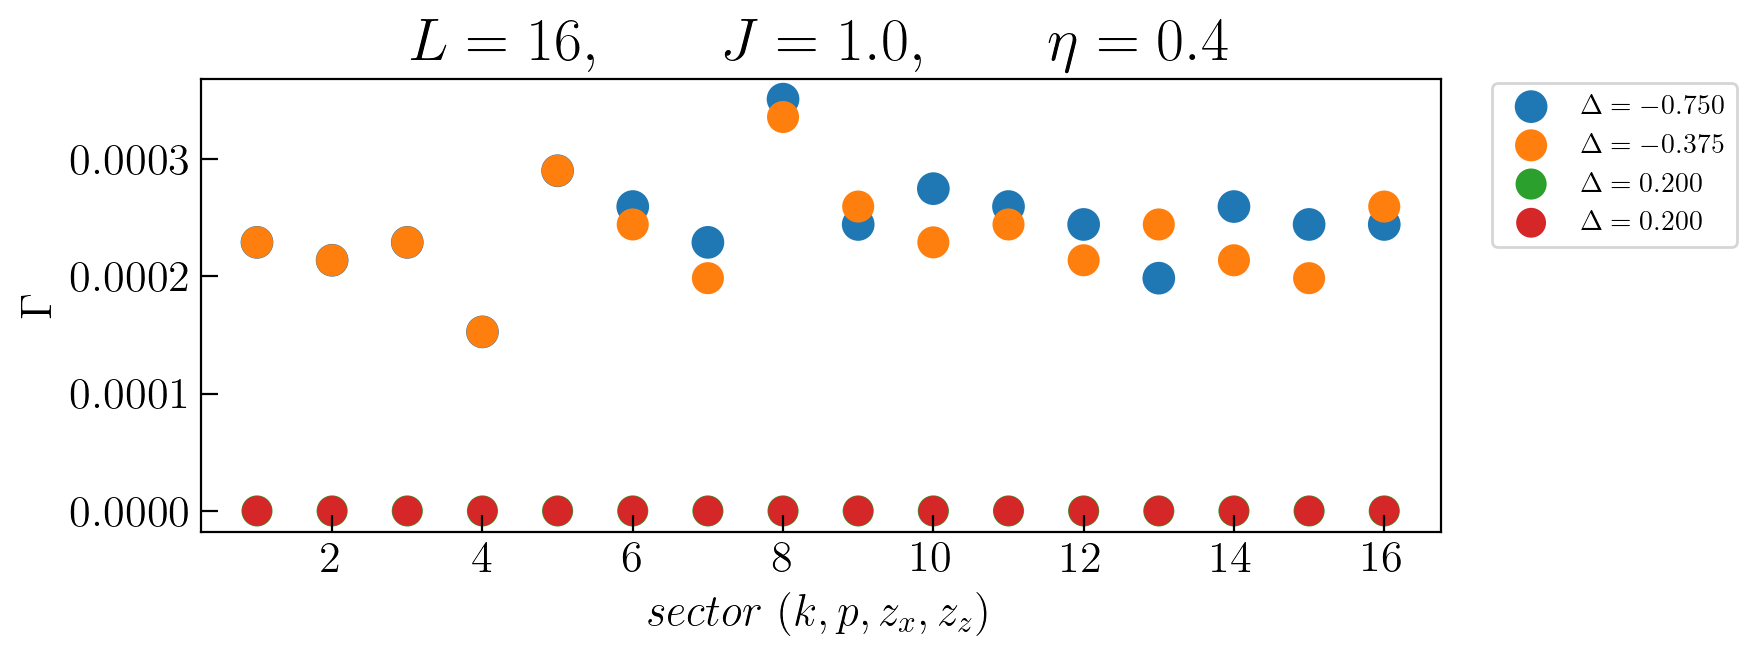

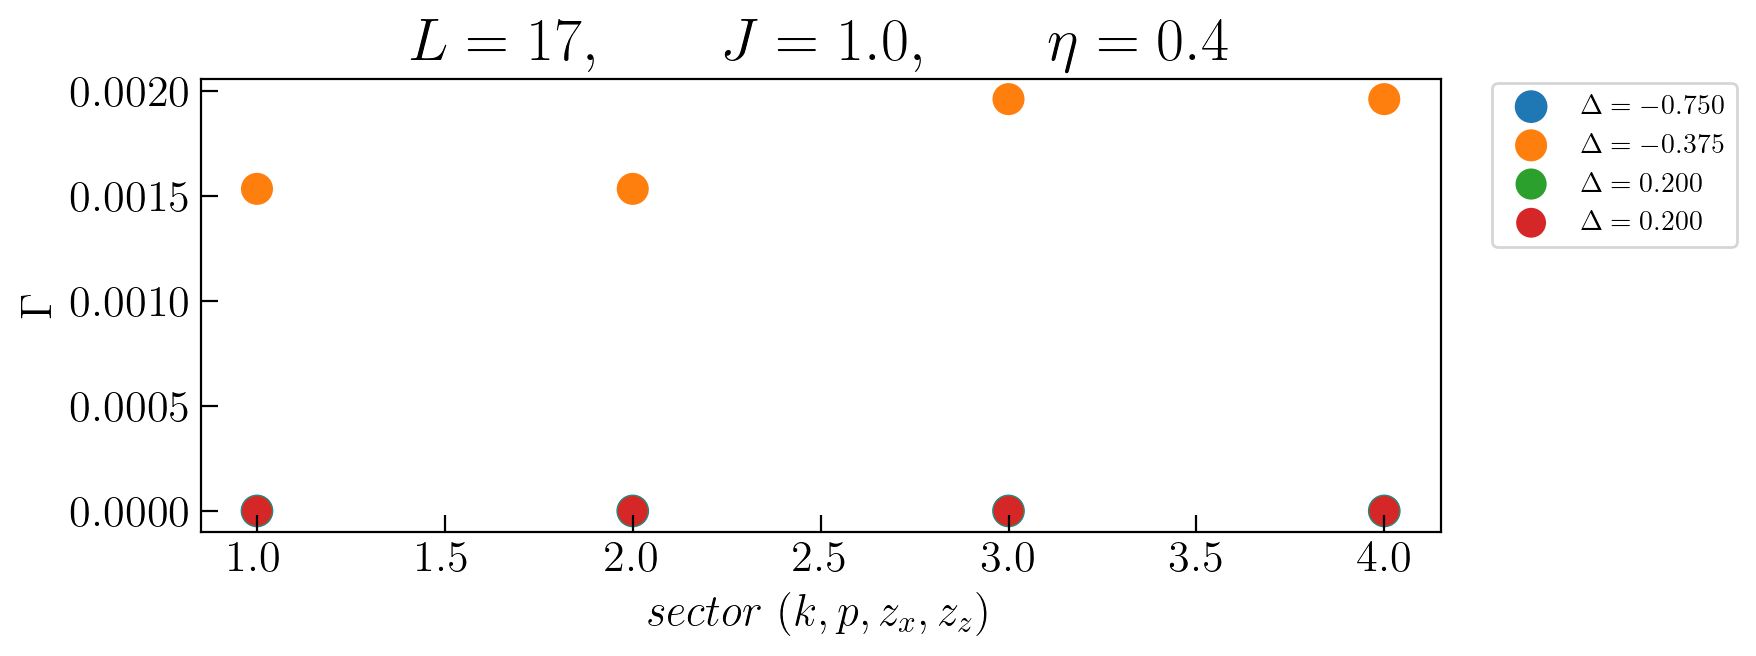

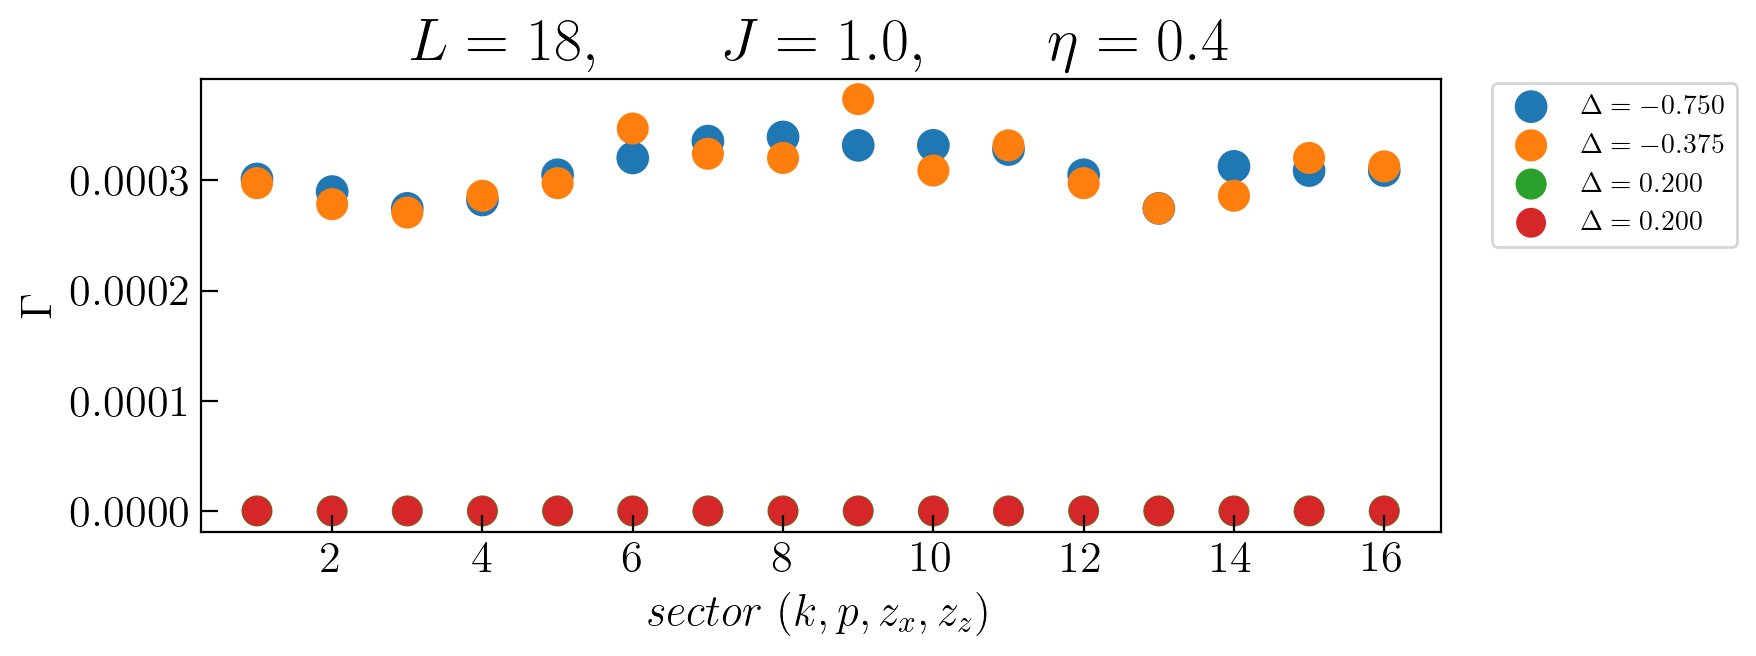

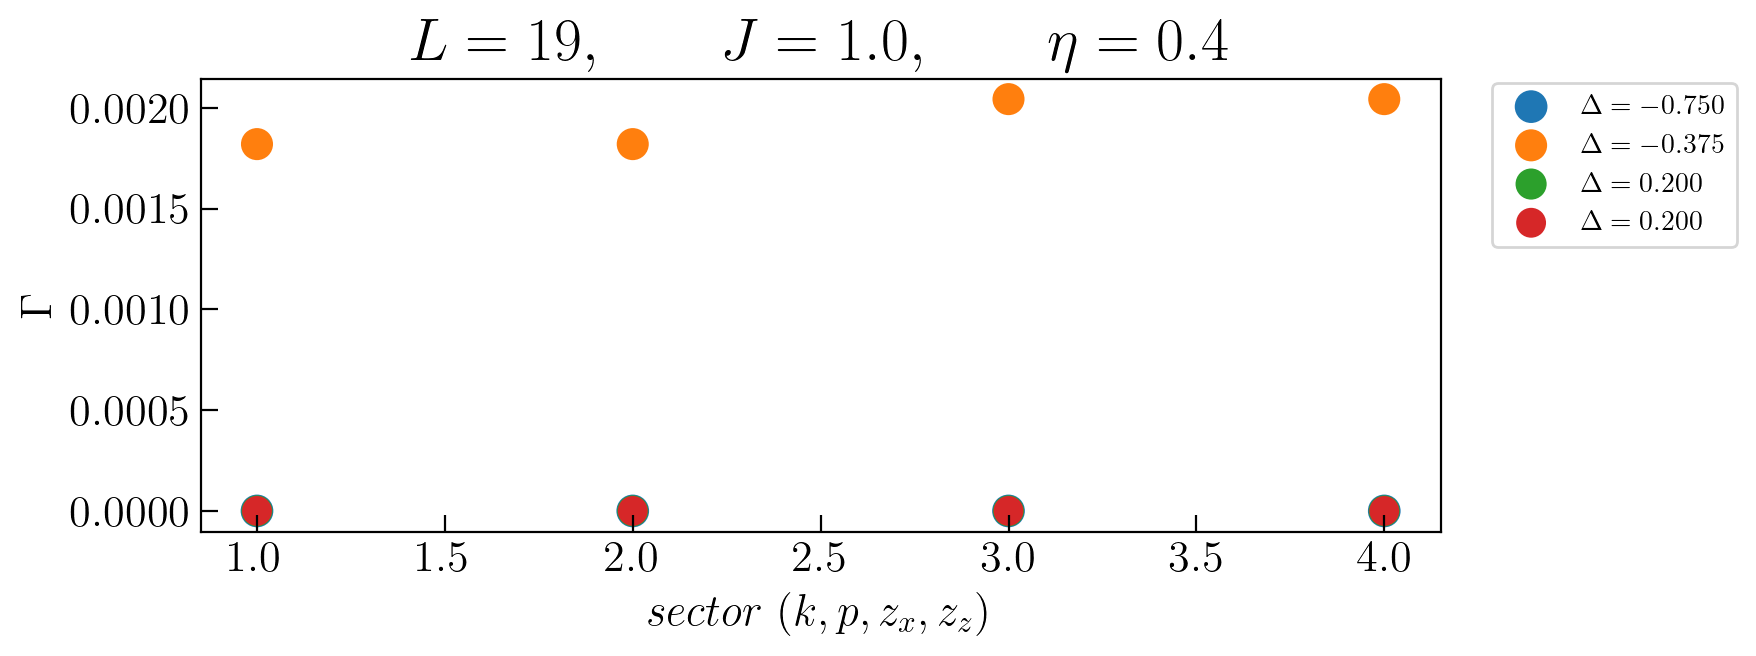

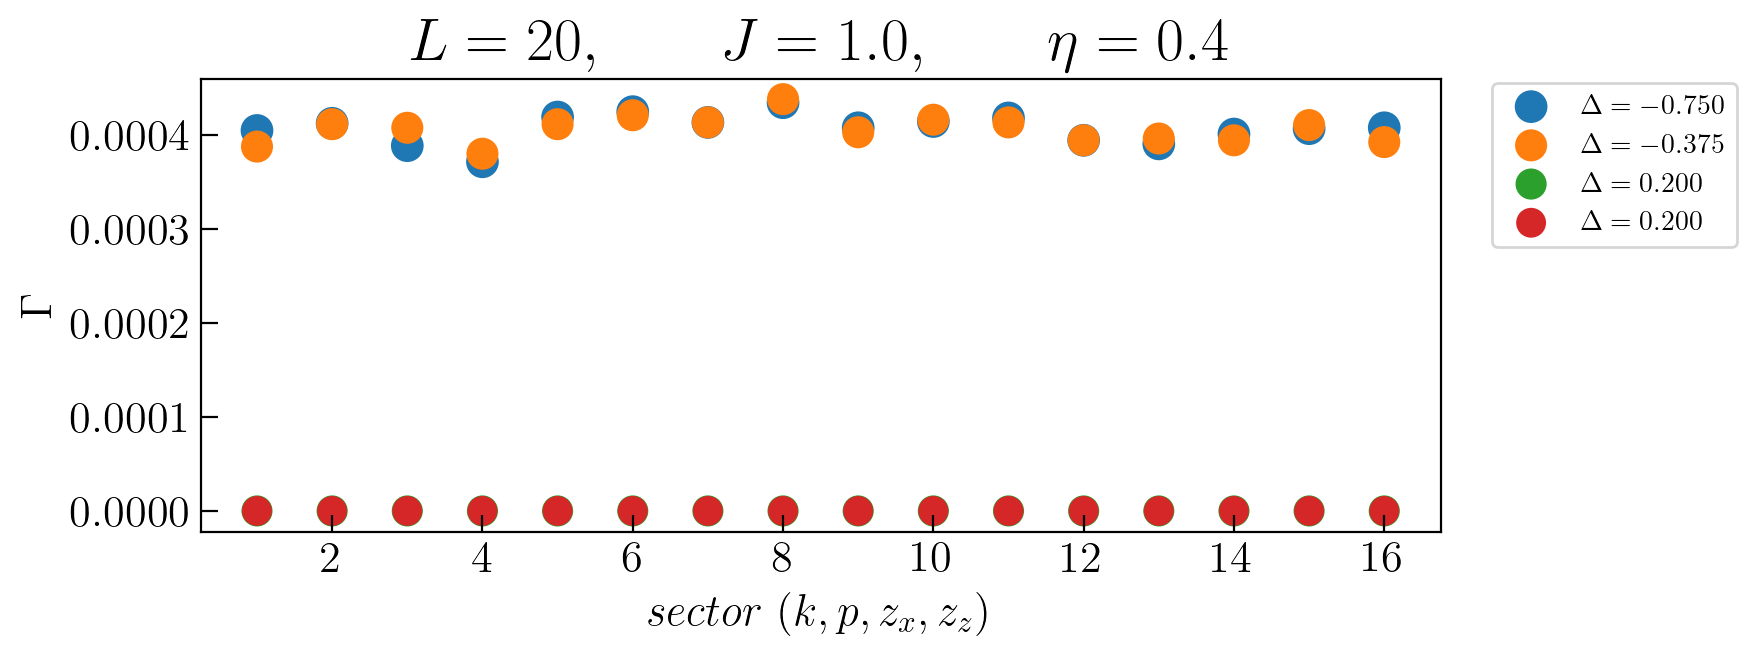

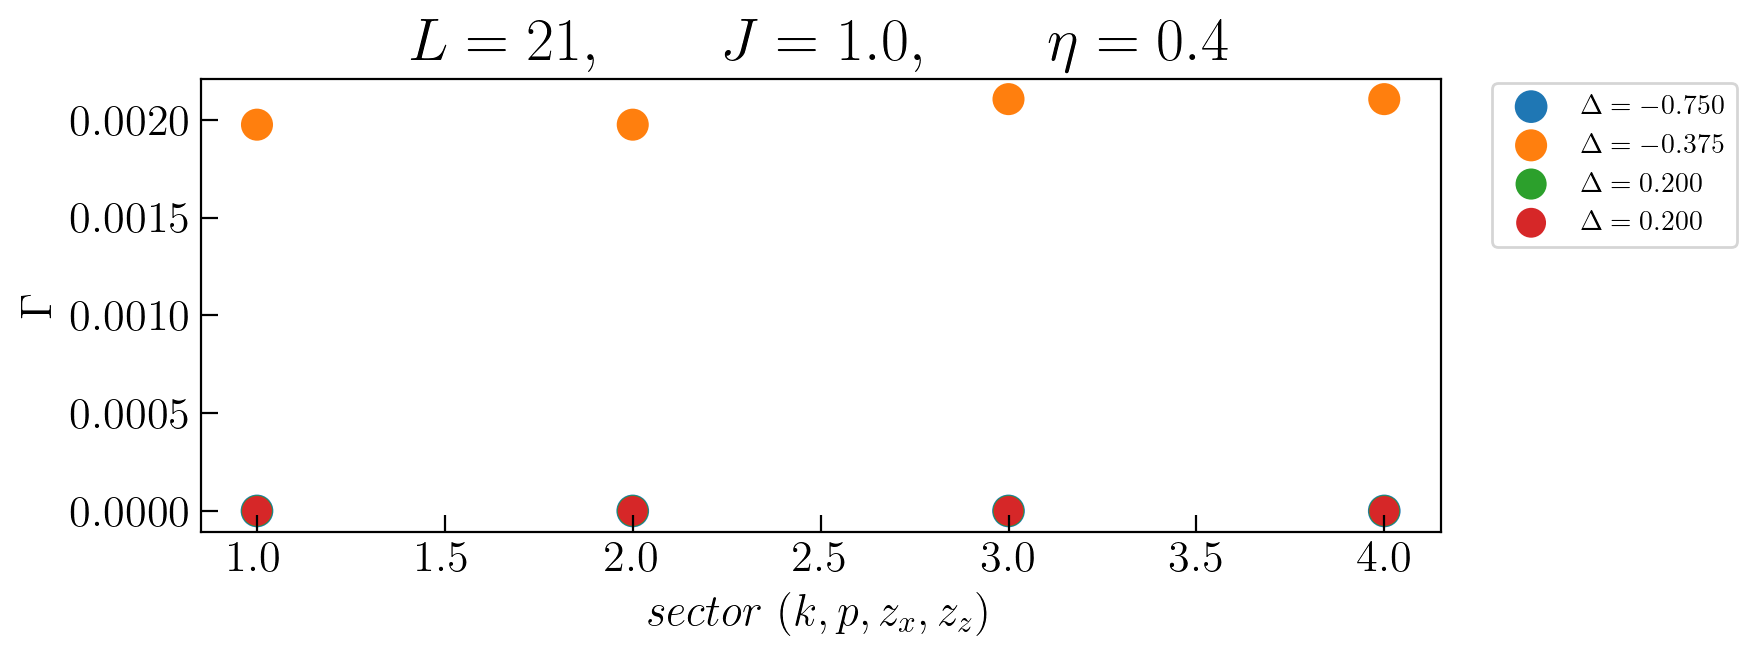

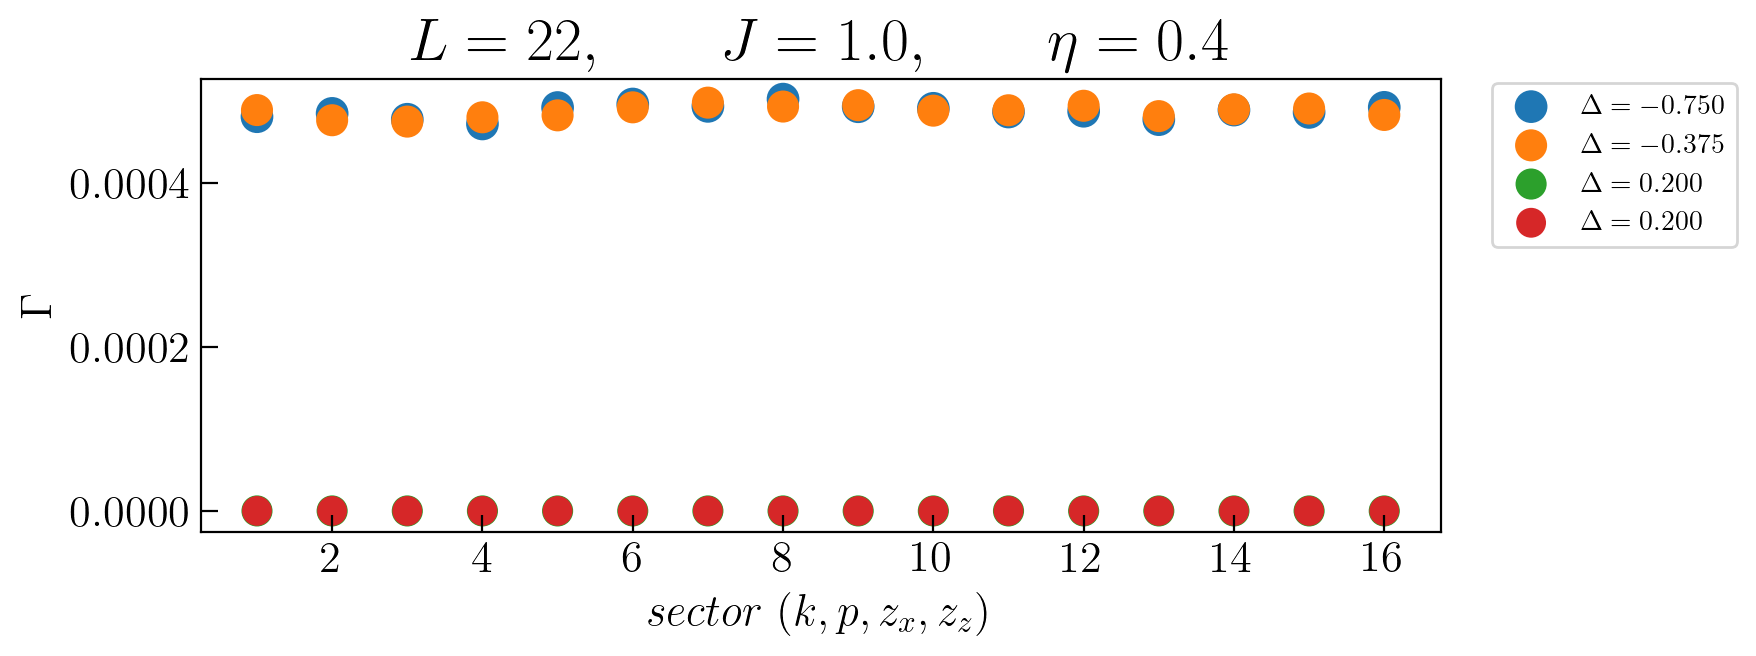

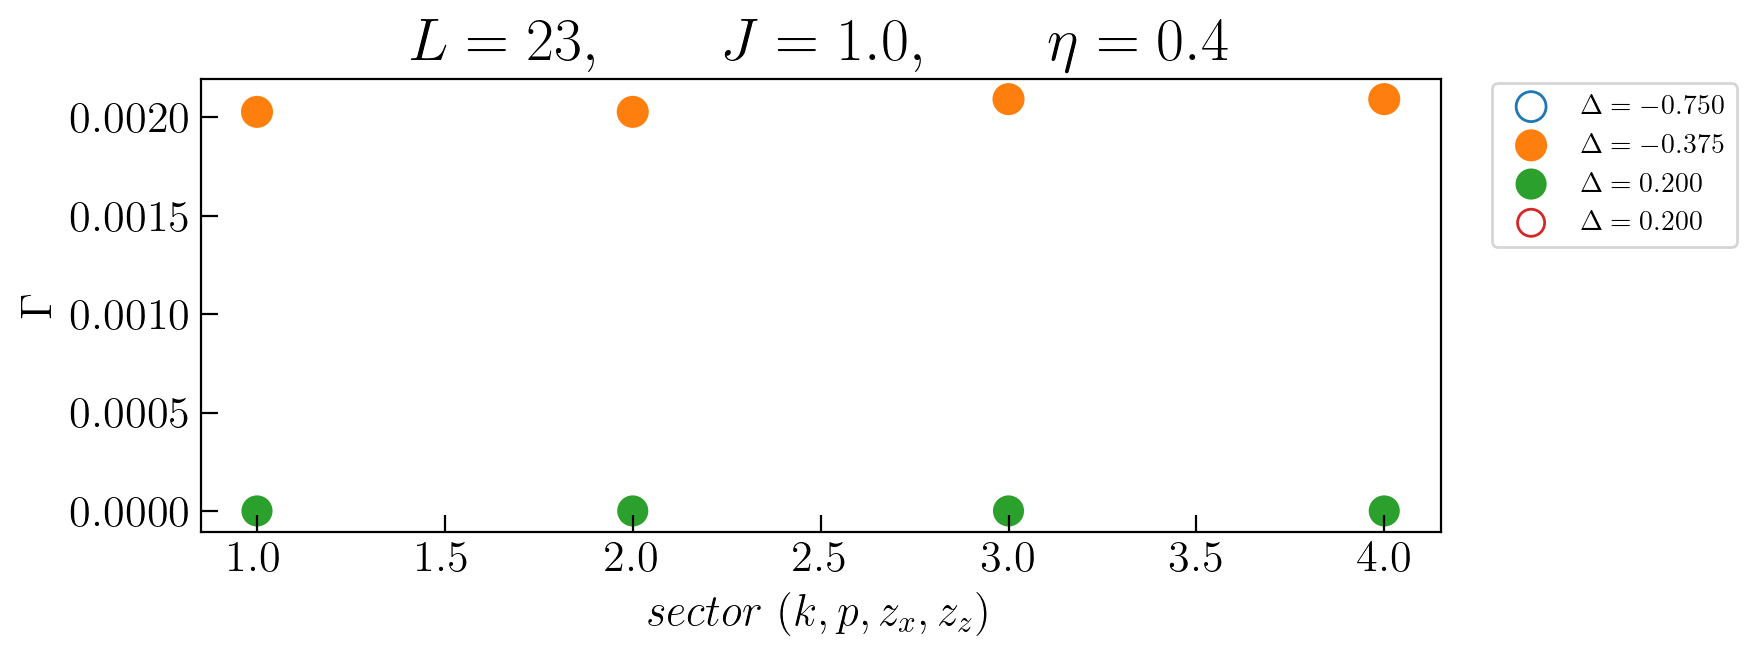

In [208]:

L=12
J1=1.0
d1=0.125
e1=0.5

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1
edge = 0
sizes = np.array([10, 11, 12, 13]) if BOUNDARY_COND == 'OBC' else np.arange(15, 24, 1)
#sizes = [10, 11, 12, 13]
deltas = np.array([ [0.5, -0.75], [0.5, -0.375], [0.2, 0.2], [0.4, 0.2]])
#deltas = [0.42, 1.05, 1.68]
degen_sum = np.zeros( (sizes.size, deltas.size) )

for jj, L in enumerate(sizes):

    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,3), dpi = 200, sharey=True, sharex=True)

    real_sec, imag_sec = get_sectors(L, hx, hz)
    sectors = [*real_sec]#, *imag_sec]
    sectors = sorted(sectors, key=lambda x: x[0])

    dim_tot = 2**L
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, [e1, d1] in enumerate(deltas):
    #for d1 in [0.75]:
        col = next(colors_ls_cyc)
        m_deg = 0
        tot_degen = []
        sector_names = []
        dim_check = 0
        fcs = []
        for [ks, ps, zxs, zzs] in (sectors):
            sec_str = ""
            if BOUNDARY_COND == 'PBC':                          sec_str += "$(%d\pi/L$,"%(2*ks)
            else:                                               sec_str += "$($"
            if BOUNDARY_COND == 'OBC' or (k==0 or k==L//2):     sec_str += "$%d$"%ps
            if hx == 0:                                         sec_str += "$,%d$"%zzs
            if hz == 0 and not edge and (L % 2 == 0 or hx != 0):sec_str += "$,%d)$"%zxs
            else:                                               sec_str += "$)$"
            sector_names.append(sec_str)

            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs, edge) + ".hdf5"
            degen_num = 0
            if exists(name):
                fcs.append(col if ks == 0 or ks == L // 2 else 'None')

                with h5py.File(name, "r") as file:
                    
                    energies = np.array(file.get('energies'))[0]
                    dim = energies.size
                    dim_check += dim

                    _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                    deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] > 1]
                    
                    tot_degen.append(len(deg_idx) / dim_tot)
            else:
                a=1
                print(name)
        max_degen_L.append(m_deg)
        print(dim_check, dim_tot)
        data = {'sectors': sector_names, 'degeneracies': tot_degen}
        
        
        ydata = np.array(data['degeneracies'])
        print(L, d1, np.sum(ydata))
        degen_sum[jj][ii] = np.sum(ydata)
        width = 0.1
        shift = 0#- width/2 + width * ii
        bins = np.array([x + shift for x in range(1, len(ydata) + 1)])
        #axis.bar(bins, ydata, width = width, label=r"$\Delta=%.3f$"%d1, linewidth=3, alpha=0.5)
        #axis.set_xticks([x for x in range(1,len(ydata) + 1)])
        
        axis.scatter(bins, ydata, label=r"$\Delta=%.3f$"%d1, edgecolors=col, facecolors=fcs, s=int(120 - (ii+2)**2))
    
    #axis.set_xticklabels(data['sectors'], rotation=90, rotation_mode="anchor", ha="right")

    axis.legend(loc='upper right', bbox_to_anchor=(1.25,1.02))
        
    axis.set_ylabel(r"$\Gamma$", fontsize=16)
    if BOUNDARY_COND == 'PBC':  axis.set_xlabel(r"$sector\ (k,p,z_x,z_z)$", fontsize=16)
    else:                       axis.set_xlabel(r"$sector\ (p,z_x,z_z)$", fontsize=16)
    axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
    
    axis.set_title(r"$L=%d,\qquad J=%.1f,\qquad \eta=%.1f$"%(L, J1, e1), fontsize=22 )


No handles with labels found to put in legend.


0.5 -0.75 [0.         0.00392151 0.         0.00495148 0.         0.00651741
 0.         0.0078032  0.        ]
0.5 -0.375 [0.00592041 0.00375366 0.00698853 0.00492859 0.00772476 0.00649929
 0.00816345 0.00779867 0.00823998]
0.2 0.2 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4 0.2 [0. 0. 0. 0. 0. 0. 0. 0. 0.]


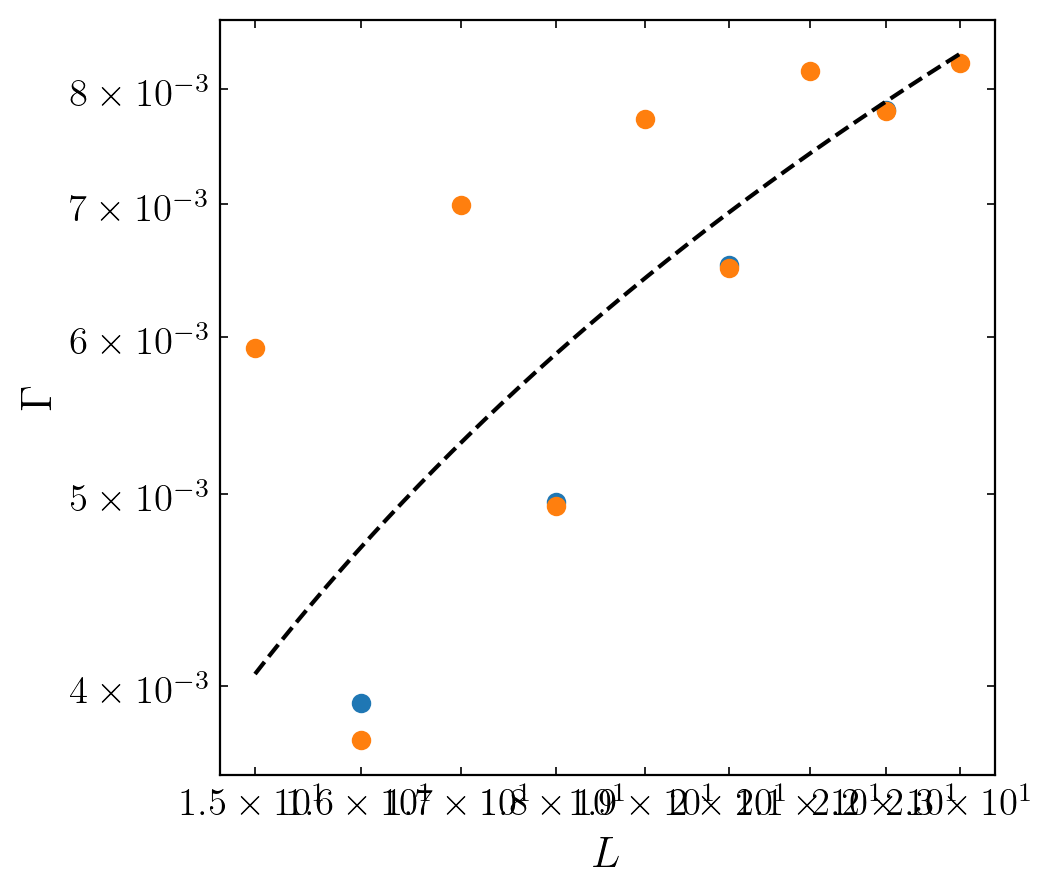

In [235]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

for ii, [e1, d1] in enumerate(deltas):
    degen = np.transpose(degen_sum)[ii]
    print(e1, d1, degen)
    axis.scatter(sizes, degen)

aa = np.linspace(sizes[0], sizes[-1], 1000)
axis.plot(aa, 1e-2 * np.log(aa / 10), ls='--', color='black')

fig_help.set_plot_elements(axis, xlabel=r"$L$", ylabel=r"$\Gamma$", font_size=14, set_legend=True, xscale='log', yscale='log')

In [181]:
2**22

4194304

waaaah 15 -0.375 0.5 30586 32768
waaaah 17 -0.375 0.5 123362 131072
waaaah 19 -0.375 0.5 496694 524288
waaaah 21 -0.375 0.5 1997294 2097152
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=2,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=2,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=3,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=3,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=23,J1=1,J2=0,d1=-0.375,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=4,zz=1,edge=0.hdf5
../results/symmetries/PBC/E

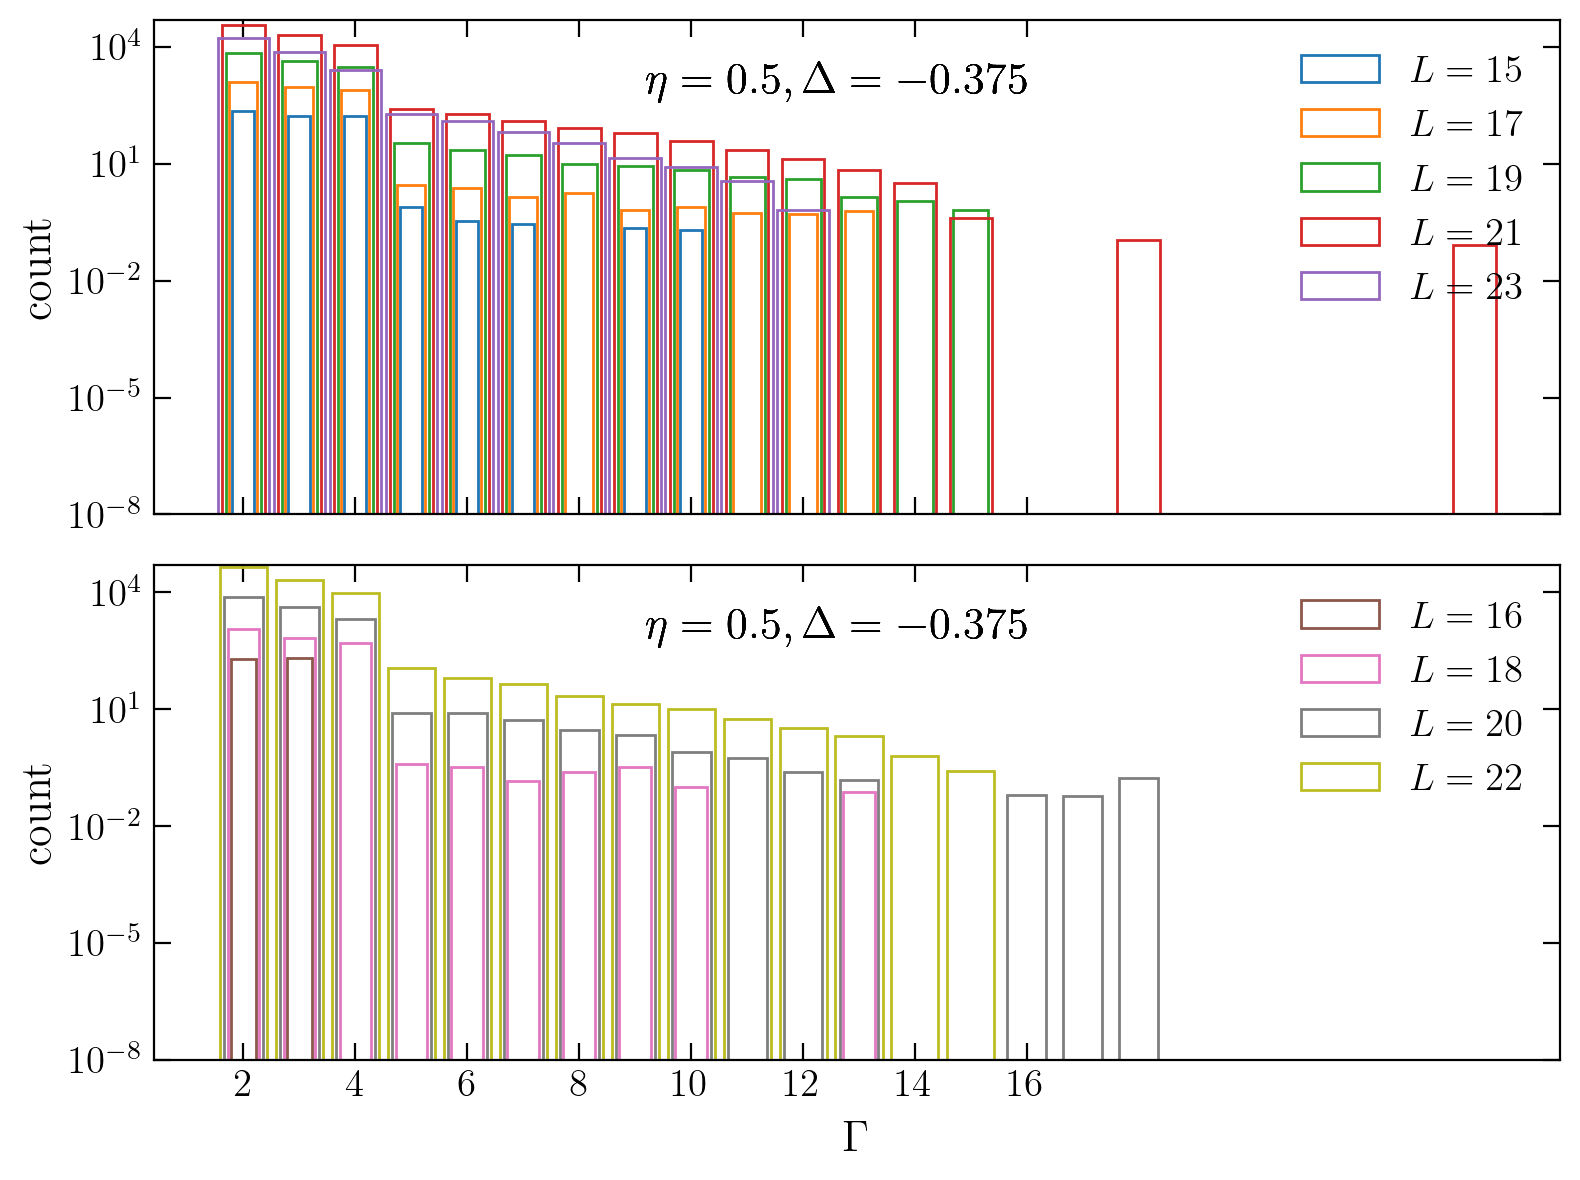

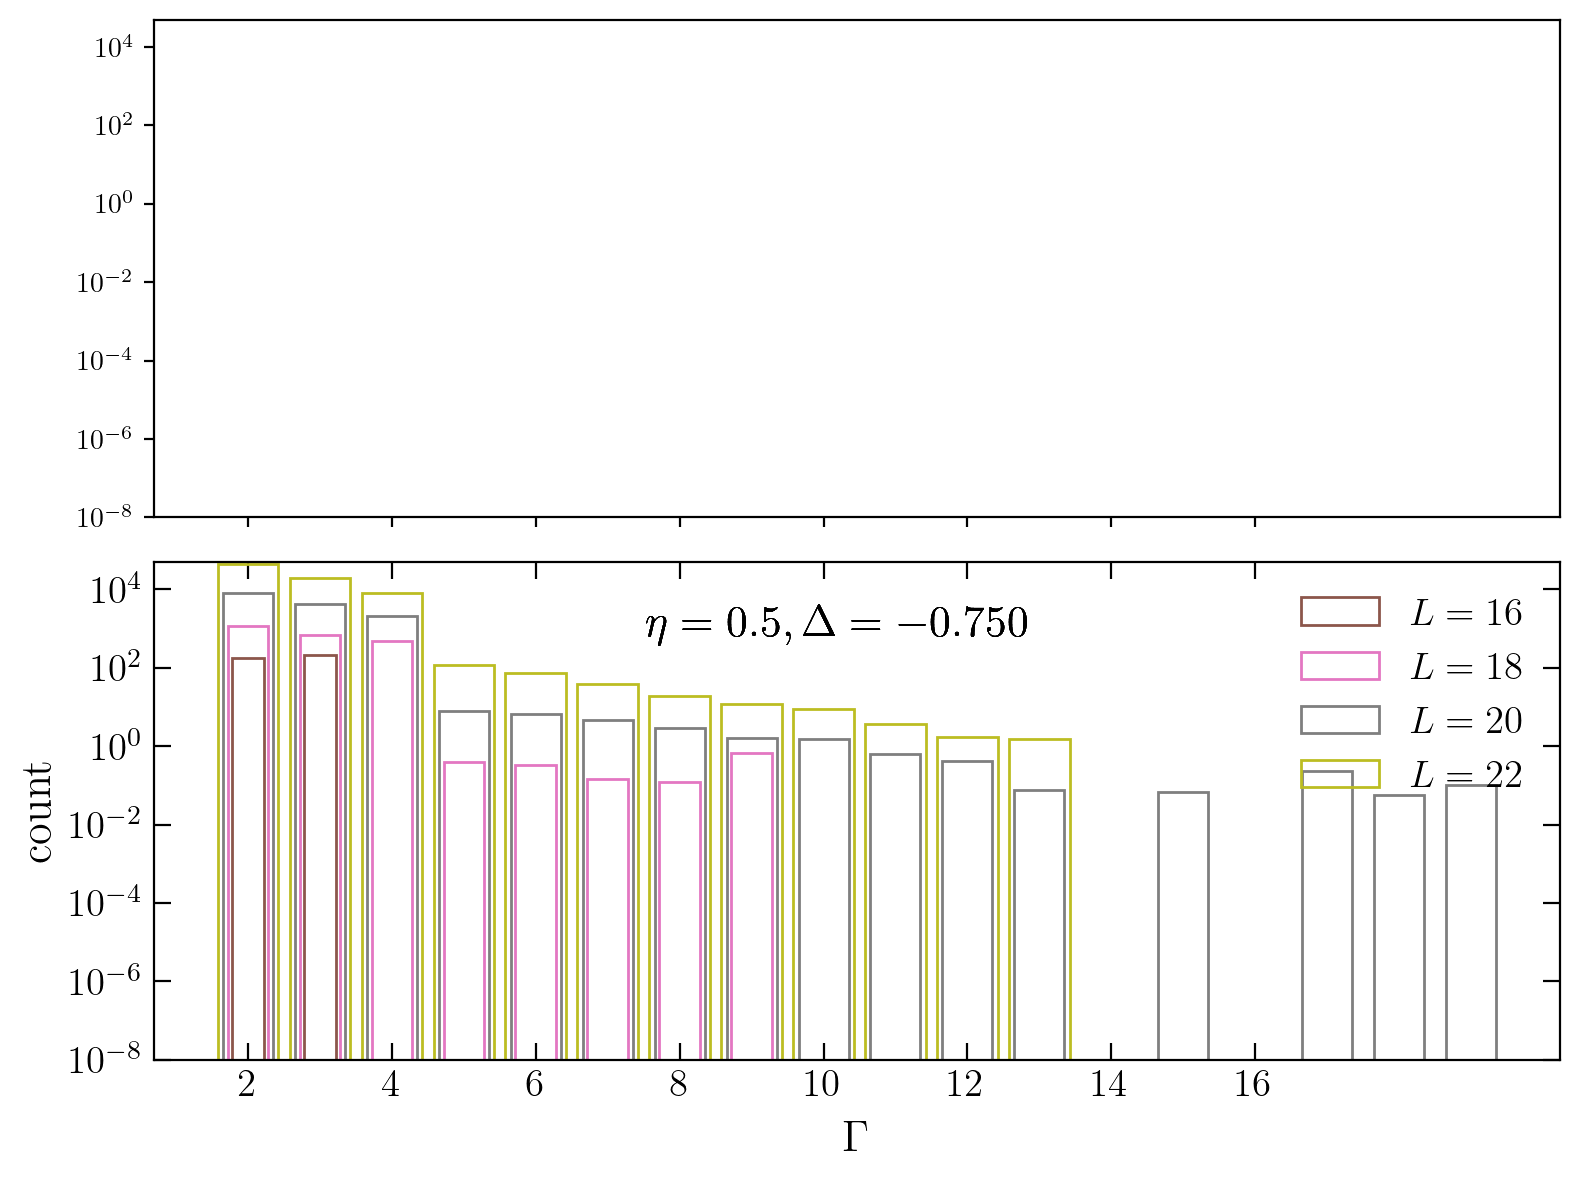

In [174]:
L=12
J1=1.0
d1=-0.375
e1=0.5


sizes = np.arange(16, 24, 2)

for [d1, e1] in [ [0.-0.375, 0.5], [-0.75, 0.5]]:

    fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(8,6), dpi = 200, sharey=True, sharex=True)
    colors_ls_cyc = itertools.cycle(colors_ls)
    ymin = 1e10
    ymax = 1e-10
    for ii, sizes in enumerate([np.arange(15, 24, 2), np.arange(16, 24, 2)]):
        for L in sizes:

            real_sec, imag_sec = get_sectors(L, 0, 0)
            sectors = [*real_sec, *imag_sec]
            sectors = sorted(sectors, key=lambda x: x[0])

            dim_tot = 2**L
            col = next(colors_ls_cyc)

            degeneracy_rank = []
            dim_check = 0
            for [ks, ps, zxs, zzs] in (sectors):

                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, edge) + ".hdf5"
                
                if exists(name):

                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('energies'))[0]

                        _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                        #deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] > 1]

                        degeneracy_rank = [*degeneracy_rank, *counts[counts > 1] ]
                        
                        dim = energies.size
                        dim_check += dim if ks == 0 or ks == L//2 else 2 * dim

                else:
                    print(name)
            if dim_check != dim_tot:
                print("waaaah", L, d1, e1, dim_check, dim_tot) 
            else:
                print(L, d1, e1)

            if len(degeneracy_rank) > 0:

                hist, edges = np.histogram(degeneracy_rank, bins = np.arange(2, max(degeneracy_rank)+1))
                
                ydata = hist / np.arange(2, max(degeneracy_rank))# / 2**L
                axis[ii].bar(np.arange(2, max(degeneracy_rank)), ydata, label=r"$L=%d$"%L, color=col, fill=False, edgecolor=col, width = L**2 / 24**2)
                
                fig_help.set_plot_elements(axis[ii], ylabel=r"count", xlabel=r"$\Gamma$" if ii > 0 else "", font_size=14, set_legend=True, yscale='log')

                xticks = [2, 4, 6, 8, 10, 12, 14, 16]
                xticklabels = ["%d"%x for x in xticks]
                axis[ii].set_xticks(xticks)
                axis[ii].set_xticklabels(xticklabels)

                axis[ii].annotate(r"$\eta=%.1f, \Delta=%.3f$"%(e1,d1), fontsize=16, xy=(0.35, 0.85), xycoords='axes fraction')
                
                if min(ydata[ydata > 0]) < ymin: ymin = min(ydata[ydata > 0])
                if max(ydata[ydata > 0]) > ymax: ymax = max(ydata[ydata > 0])

    axis[0].set_ylim(1e-8, 1.1*ymax)

    fig.tight_layout()
    plt.savefig(f"PLOTS/Degeneracye1={e1},d1={d1}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    plt.savefig(f"PLOTS/Degeneracye1={e1},d1={d1}.png", bbox_inches = 'tight', pad_inches=0.02)

In [161]:
Ls_e=[12, 14, 16, 18, 20]
Ls_o=[13, 15, 17, 19]
print("OBC even", [int(2**L / (8)) for L in Ls_e])
print("OBC odd", [int(2**L / (4)) for L in Ls_o])

Ls_e=[16, 18, 20, 22, 24]
Ls_o=[15, 17, 19, 21, 23]
print("PBC even real", [int(2**L / (8*L)) for L in Ls_e])
print("PBC odd real", [int(2**L / (4*L)) for L in Ls_o])

print("PBC even imag", [int(2**L / (4*L)) for L in Ls_e])
print("PBC odd imag", [int(2**L / (2*L)) for L in Ls_o])

OBC even [512, 2048, 8192, 32768, 131072]
OBC odd [2048, 8192, 32768, 131072]
PBC even real [512, 1820, 6553, 23831, 87381]
PBC odd real [546, 1927, 6898, 24966, 91180]
PBC even imag [1024, 3640, 13107, 47662, 174762]
PBC odd imag [1092, 3855, 13797, 49932, 182361]


## DOS & ENERGY STATISTICS

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


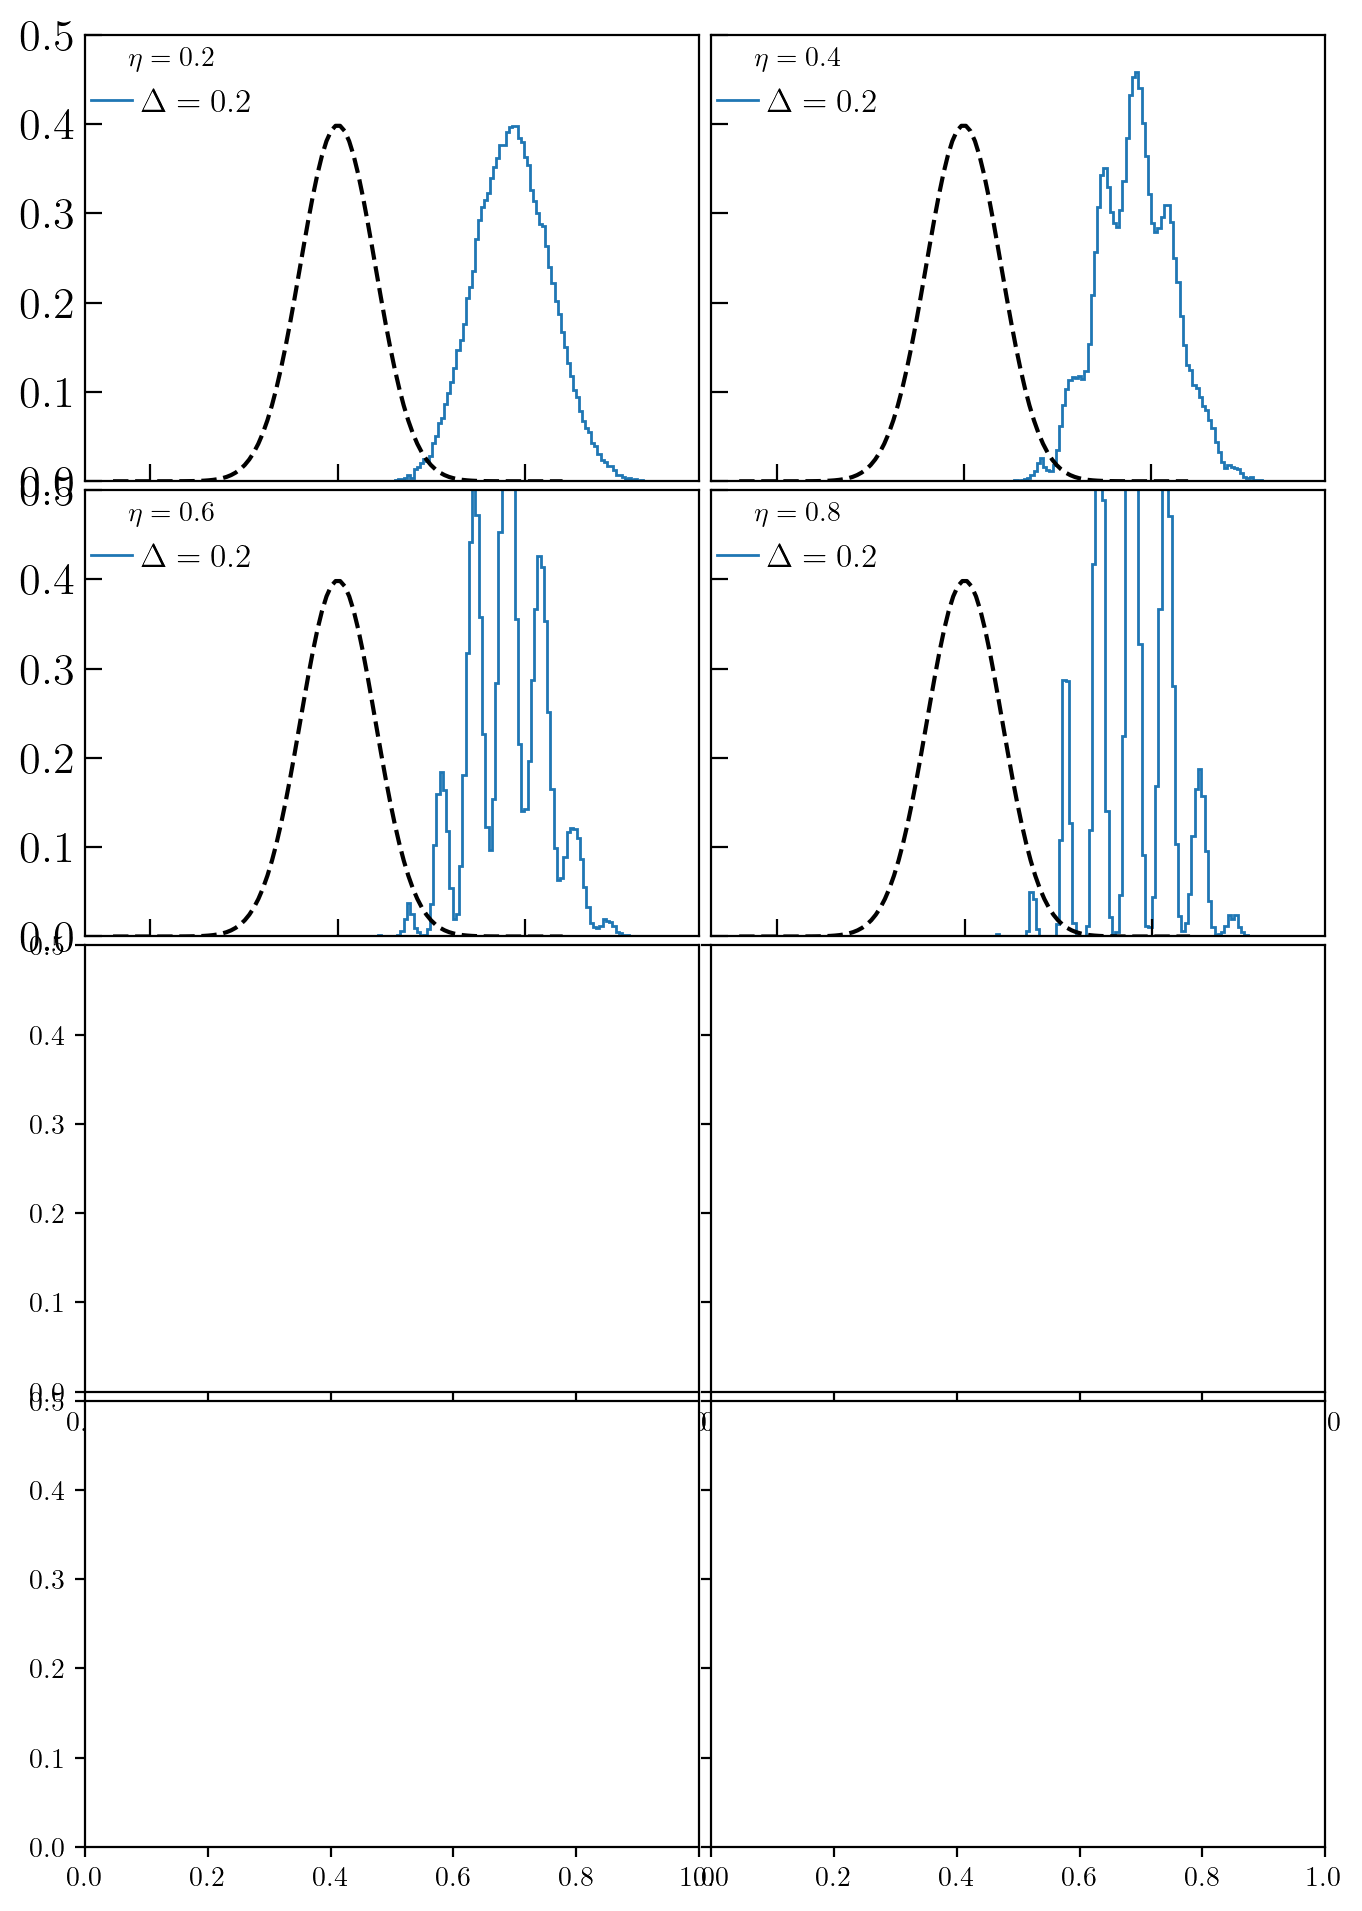

In [26]:

markers = itertools.cycle(markers_ls)

L=20

J1=1.0
d1=0.5
e1=0.3

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 0.25 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=4, ncols=2, figsize=(8,12), dpi = 200, sharey=True)
axis = np.array(axis).flatten()

# deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


real_sec, _ = get_sectors(L, hx, hz)

pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
for jj, e1 in enumerate([0.2, 0.4, 0.6, 0.8]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, d1 in enumerate([0.2]):
        entropy = []
        energy = []
        for [ks, ps, zxs, zzs] in real_sec:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    entropies = np.array(file.get('entropy'))[LA]
                    
                    energies /= np.std(energies)
                    
                    energy = [*energy, *energies]
                    entropy = [*entropy, *entropies]
            else:
                print(name)

        #axis[jj].scatter(energy[::3], entropy[::3], s=(25 - 5 * ii), label=f"$\Delta={d1}$", color = next(colors_ls_cyc), facecolor='None')
        bins, hist = np.histogram(energy, bins=100, normed=True)
        axis[jj].stairs(bins, hist, label=f"$\Delta={d1}$", color = next(colors_ls_cyc))
    
    legend = axis[jj].legend(frameon=False, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.04))
    legend.set_title(f"$\eta={e1}$")
    en = np.linspace(-6, 6, 100)
    axis[jj].plot(en, 1/np.sqrt(2*np.pi) * np.exp(-en**2/2), ls='--', color='black')
    axis[jj].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    axis[jj].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

axis[0].set_ylim(0, 0.5)
fig.subplots_adjust(wspace = 0.02, hspace=0.02)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.    ]


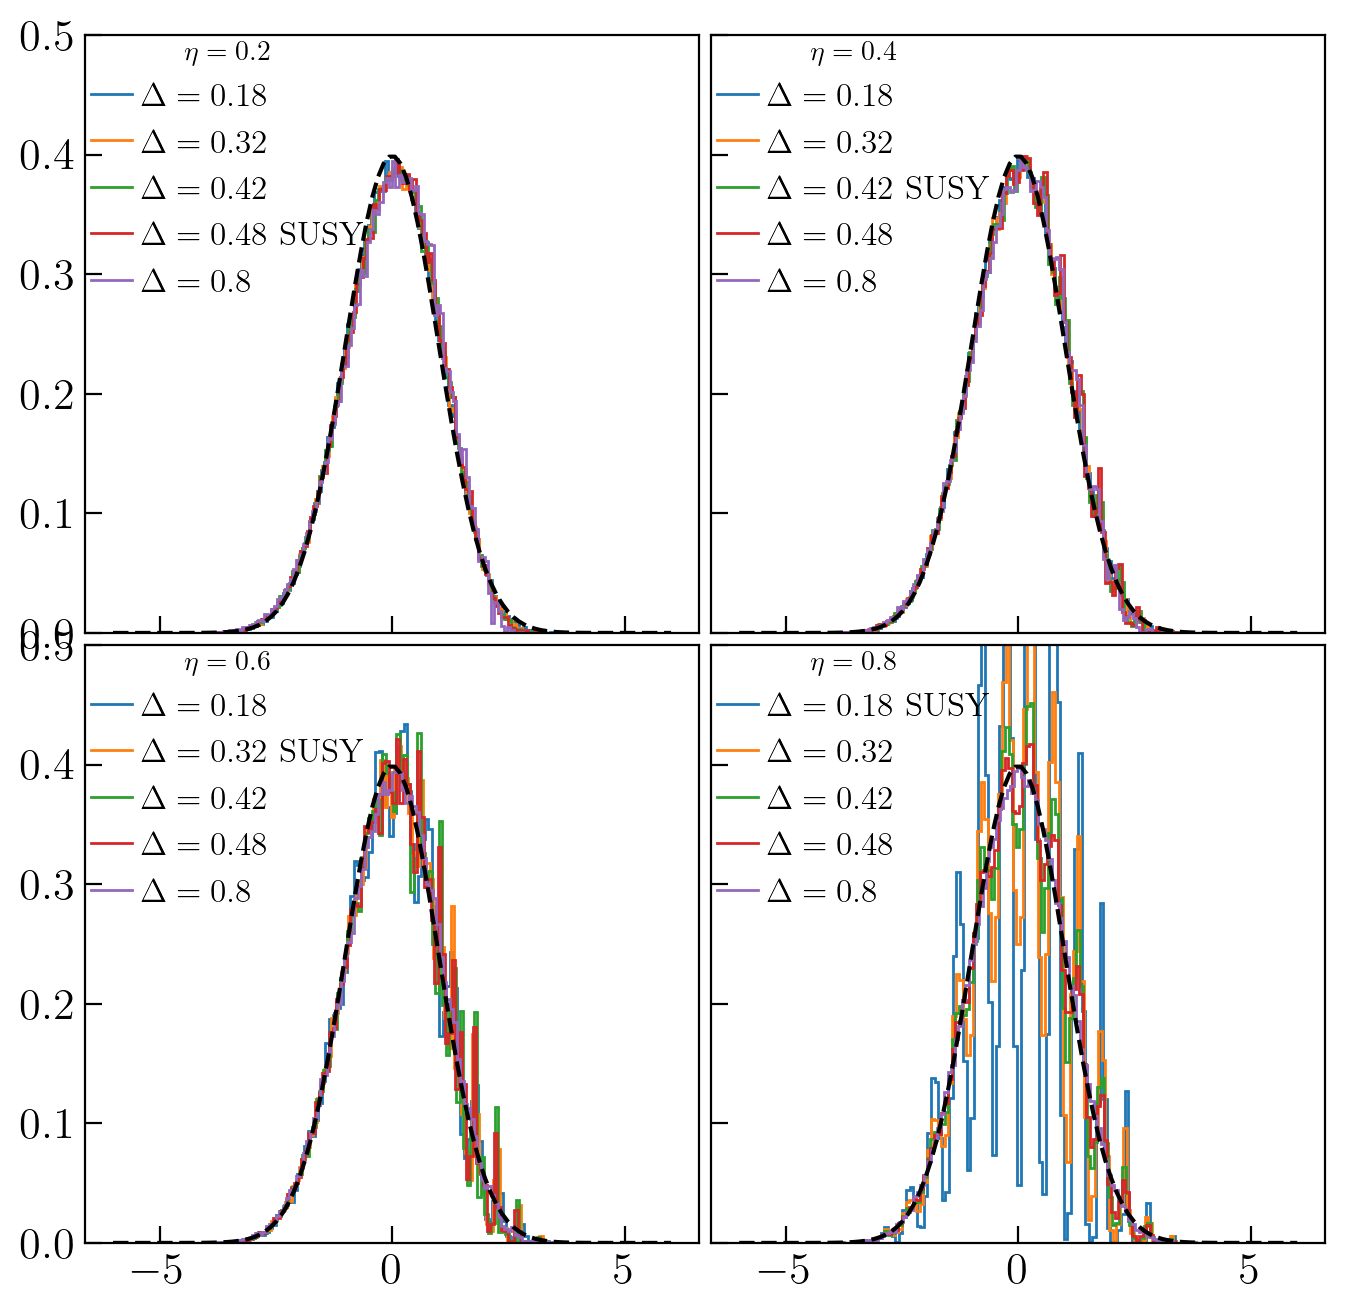

In [20]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.5
e1=0.3

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 0.25 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(8,8), dpi = 200, sharey=True, sharex=True)
axis = np.array(axis).flatten()

# deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


real_sec, _ = get_sectors(L, hx, hz)

dim_tot = 2**L

subsystem_frac = np.linspace(0, 1, L+1)
print(subsystem_frac)
for jj, e1 in enumerate([0.2, 0.4, 0.6, 0.8]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, d1 in enumerate([0.18, 0.32, 0.42, 0.48, 0.8]):
        entropy = []
        energy = []
        for [ks, ps, zxs, zzs] in real_sec:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    entropies = np.array(file.get('entropy'))[LA]
                    
                    energies /= np.std(energies)
                    
                    energy = [*energy, *energies]
                    entropy = [*entropy, *entropies]
            else:
                print(name)

        #axis[jj].scatter(energy[::3], entropy[::3], s=(25 - 5 * ii), label=f"$\Delta={d1}$", color = next(colors_ls_cyc), facecolor='None')
        bins, hist = np.histogram(energy, bins=100, normed=True)
        _app = " SUSY" if np.abs(d1 - 0.5*(1-e1**2)) < 1e-10 else ""
        axis[jj].stairs(bins, hist, label=f"$\Delta={d1}$" + _app, color = next(colors_ls_cyc))
    
    legend = axis[jj].legend(frameon=False, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.04))
    legend.set_title(f"$\eta={e1}$")
    en = np.linspace(-6, 6, 100)
    axis[jj].plot(en, 1/np.sqrt(2*np.pi) * np.exp(-en**2/2), ls='--', color='black')
    axis[jj].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    axis[jj].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

axis[0].set_ylim(0, 0.5)
fig.subplots_adjust(wspace = 0.02, hspace=0.02)

## ENTROPY

[0.      0.00995 0.0198  0.02955 0.0392  0.04875 0.0582  0.06755 0.0768
 0.08595 0.095   0.10395 0.1128  0.12155 0.1302  0.13875 0.1472  0.15555
 0.1638  0.17195 0.18    0.18795 0.1958  0.20355 0.2112  0.21875 0.2262
 0.23355 0.2408  0.24795 0.255   0.26195 0.2688  0.27555 0.2822  0.28875
 0.2952  0.30155 0.3078  0.31395 0.32    0.32595 0.3318  0.33755 0.3432
 0.34875 0.3542  0.35955 0.3648  0.36995 0.375   0.37995 0.3848  0.38955
 0.3942  0.39875 0.4032  0.40755 0.4118  0.41595 0.42    0.42395 0.4278
 0.43155 0.4352  0.43875 0.4422  0.44555 0.4488  0.45195 0.455   0.45795
 0.4608  0.46355 0.4662  0.46875 0.4712  0.47355 0.4758  0.47795 0.48
 0.48195 0.4838  0.48555 0.4872  0.48875 0.4902  0.49155 0.4928  0.49395
 0.495   0.49595 0.4968  0.49755 0.4982  0.49875 0.4992  0.49955 0.4998
 0.49995 0.5     0.49995 0.4998  0.49955 0.4992  0.49875 0.4982  0.49755
 0.4968  0.49595 0.495   0.49395 0.4928  0.49155 0.4902  0.48875 0.4872
 0.48555 0.4838  0.48195 0.48    0.47795 0.4758  0.47355 0.4

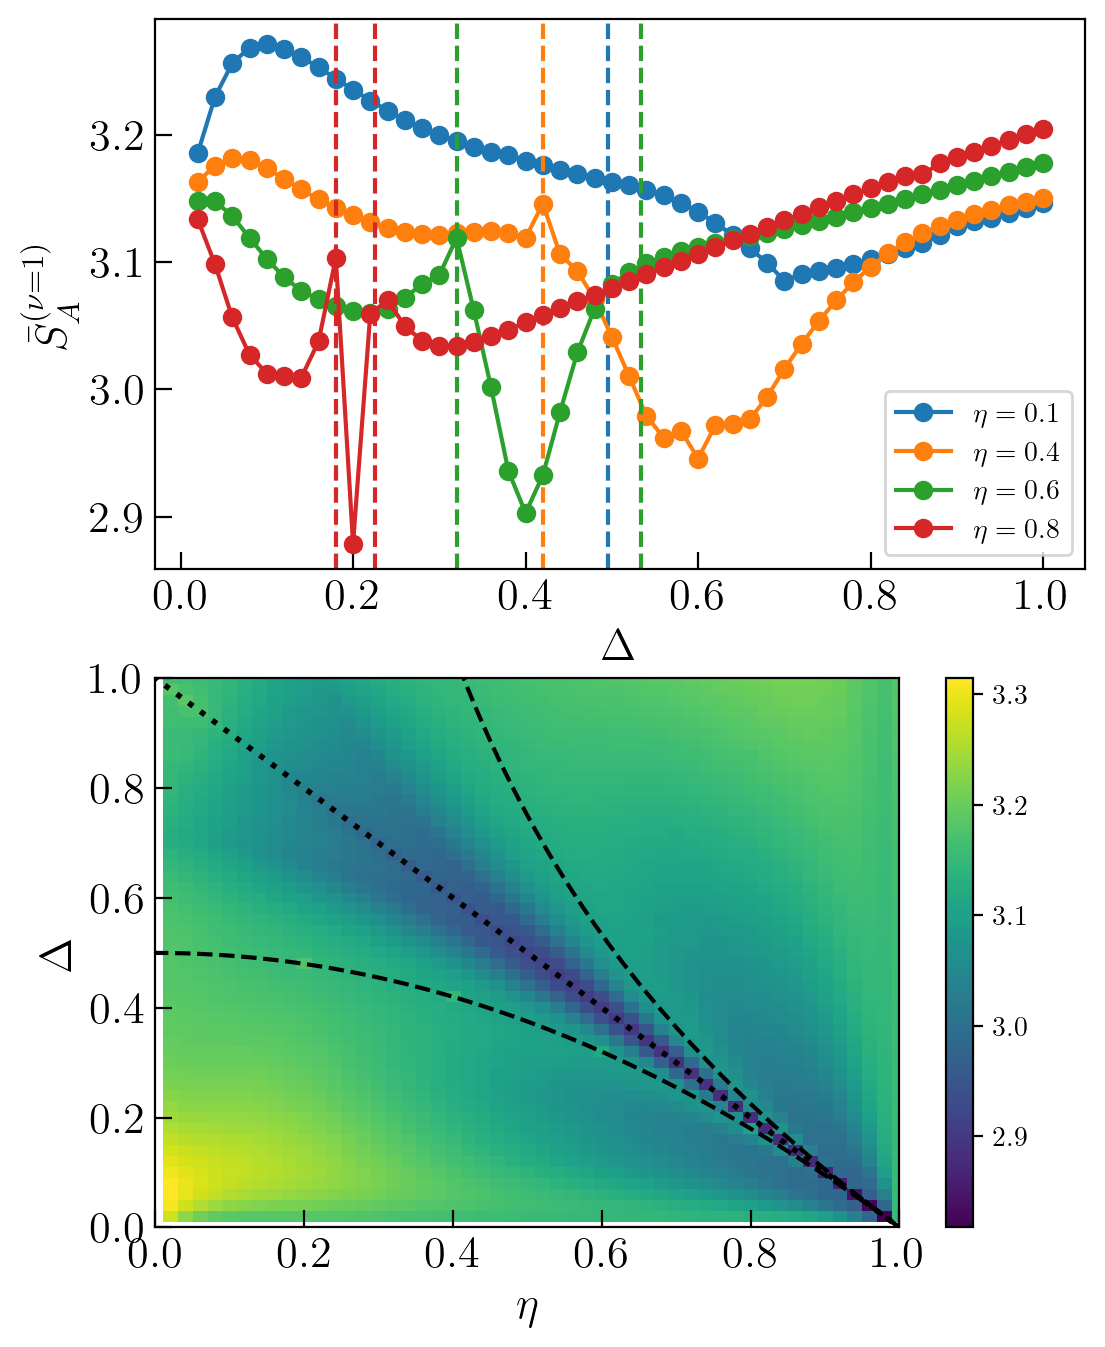

In [182]:

fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(6,8), dpi = 200)
L=16

df = pd.read_csv(f'./RESULTS/OBC/entropy_sweep_nu=1_L={L}.csv') 

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

X, Y = np.meshgrid(etas, deltas)
p = axis[1].pcolormesh(X, Y, np.array(df['LA=8']).reshape((50, 50)), shading='nearest')#, cmap='gnuplot')

def delta1(eta):
    return (1 - eta**2) / 2

def delta2(eta):
    return (1 - eta**2) / (2 * eta)

new_etas = np.linspace(-1, 1, 201)

print(delta1(new_etas))
print(delta2(new_etas))
axis[1].plot(new_etas, delta1(new_etas), c='black', ls='--')
axis[1].plot(new_etas, -delta1(new_etas), c='red', ls='--')
axis[1].plot(new_etas, delta2(new_etas), c='black', ls='--')
axis[1].plot(new_etas, -delta2(new_etas), c='black', ls='--')
axis[1].plot(new_etas, 1-(new_etas), c='black', ls=':', lw=2)
axis[1].plot(new_etas, 1+(new_etas), c='black', ls=':', lw=2)
fig.colorbar(p)

axis[1].set_xlim(0, 1)
axis[1].set_ylim(0, 1)

axis[1].set_xlabel('$\eta$', fontsize=16)
axis[1].set_ylabel('$\Delta$', fontsize=16)
axis[1].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis[1].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

#axis[1].set_title(r'$\bar S_A^{(\nu=1)}$', fontsize=20)

for eta in [0.1, 0.2, 0.4, 0.6, 0.8]:
    entropy = df[ df['eta'] == eta ]['LA=8']
    if len(entropy) == 50:
        pl = axis[0].plot(deltas, entropy, marker='o', label=f"$\eta={eta}$")
    
        supersym_point = [delta1(eta), delta2(eta)]
        for sp in supersym_point:
            if sp < 1.0:
                axis[0].axvline(x=sp, ls='--', color=pl[0].get_color())

axis[0].set_xlabel('$\Delta$', fontsize=16)
axis[0].set_ylabel(r'$\bar S_A^{(\nu=1)}$', fontsize=16)
axis[0].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis[0].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
axis[0].legend()


#plt.savefig("entropy_sweep.pdf", bbox_inches = 'tight', pad_inches=0.02)
#plt.savefig("entropy_sweep.png", bbox_inches = 'tight', pad_inches=0.02)

In [23]:
J1=1.0
sizes = [14, 16]

deltas = -0.5 + np.linspace(0.0, 1.00, 51)
etas = -0.5 + np.linspace(0.0, 1.00, 51)
print(etas, deltas)


def loop_body(nu):
    frac = lambda dim: (nu if nu > 2 else (nu * dim if nu < 1.0 else dim + 1))
    
    for L in sizes:
        subsystem_frac = np.linspace(0, L//2, L//2 + 1).astype(int)

        real_sec, imag_sec = get_sectors(L, 0.0, 0.0)
        
        gap_ratio = []
        entropy = [[] for _ in subsystem_frac]
        entropy_var = [[] for _ in subsystem_frac]
        gaussianity1 = []
        gaussianity2 = []
        
        delta_all = []
        eta_all = []
        
        for delta1 in deltas:
            for eta1 in etas:
                dim_tot = 0
                Etot = []
                Stot = [[] for _ in subsystem_frac]

                ratio = 0
                entro = np.zeros((subsystem_frac.size))
                gauss = 0

                counter = 0
                for [ks, ps, zxs, zzs] in (real_sec + imag_sec):
                    name = base_dir + 'Entropy/Eigenstate2/' + info_sym(L=L, J1=J1, delta1=delta1, eta1=eta1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                    if exists(name):
                        with h5py.File(name, "r") as file:
                            energies = np.array(file.get('energies')[0])
                            Etot = [*Etot, *energies]

                            dim = energies.size
                            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                            num = frac(dim)

                            E_av = np.mean(energies)
                            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))

                            gauss += (dim if ks == 0 or ks == L / 2 else 2 * dim) * np.var(energies) / np.mean(energies)**2
                            
                            my_min = int(index_meanE - num / 2)
                            if my_min < 0: my_min = 0;  

                            my_max = int(index_meanE + num / 2)
                            if my_max >= dim: my_max = dim
                        
                            

                            gaps = np.diff(energies)
                            if num < dim and my_min > 0 and my_max < dim:
                                gaps = np.diff(energies[my_min : my_max])
                            
                            ratio_tmp = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
                            ratio += np.mean(ratio_tmp)
                            counter += 1

                            for LA in subsystem_frac:
                                entropies = np.array(file.get('entropy'))[LA]
                                Stot[LA] = [*Stot[LA], *entropies]
                                sample = entropies
                                if num < dim and my_min > 0 and my_max < dim:
                                    sample = entropies[my_min : my_max]
                                
                                entro[LA] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
                            
                    else:
                        print(name)
                if dim_tot != 2**L:
                    print("waaaaaaa", dim_tot, 2**L)
                
                for LA in subsystem_frac:
                    entropy[LA].append(entro[LA] / dim_tot)
                    entropy_var[LA].append(np.var(Stot[LA]))
                
                gap_ratio.append(ratio / counter)
                gaussianity1.append(gauss / dim_tot)
                gaussianity2.append(np.var(np.array(Etot)) / np.mean(np.array(Etot))**2)
                
                delta_all.append(d1)
                eta_all.append(e1)

            print(L, d1, "---------------------------------------------------- DONE")

        d = {'d1':  np.array(delta_all), 'e1': np.array(eta_all), 'gaussianity1': np.array(gaussianity1), 'gaussianity2': np.array(gaussianity2), 'gap_ratio': np.array(gap_ratio)}

        for LA in subsystem_frac:
            d[f'S_LA={LA}']      = np.array(entropy[LA])
            d[f'S2_LA={LA}']     = np.array(entropy_var[LA])

        df = pd.DataFrame(data=d)
        print(df) 
        df.to_csv(f'./RESULTS/param_sweep_L={L}_nu={nu}.csv')

Parallel(n_jobs=5)(delayed(loop_body)(nu) for nu in [100, 0.1, 0.25, 0.5, 1.0])
        

[-0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28
 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04
 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2
  0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44
  0.46  0.48  0.5 ] [-0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28
 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04
 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2
  0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44
  0.46  0.48  0.5 ]


/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide


14 -0.5 ---------------------------------------------------- DONE
14 -0.5 ---------------------------------------------------- DONE
14 -0.5 ---------------------------------------------------- DONE
14 -0.5 ---------------------------------------------------- DONE
14 -0.5 ---------------------------------------------------- DONE
14 -0.48 ---------------------------------------------------- DONE
14 -0.48 ---------------------------------------------------- DONE
14 -0.48 ---------------------------------------------------- DONE
14 -0.48 ---------------------------------------------------- DONE
14 -0.48 ---------------------------------------------------- DONE
14 14-0.46  ---------------------------------------------------- DONE
-0.46 ---------------------------------------------------- DONE
14 -0.46 ---------------------------------------------------- DONE
14 -0.46 ---------------------------------------------------- DONE
14 -0.46 ---------------------------------------------------- DONE


/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide


14 -0.21999999999999997 ---------------------------------------------------- DONE
14 -0.21999999999999997 ---------------------------------------------------- DONE
14 -0.21999999999999997 ---------------------------------------------------- DONE
14 -0.21999999999999997 ---------------------------------------------------- DONE
14 -0.21999999999999997 ---------------------------------------------------- DONE
14 -0.2 ---------------------------------------------------- DONE14 
-0.2 ---------------------------------------------------- DONE
14 -0.2 ---------------------------------------------------- DONE
14 -0.2 ---------------------------------------------------- DONE
14 -0.2 ---------------------------------------------------- DONE
14 -0.18 ---------------------------------------------------- DONE
14 -0.18 ---------------------------------------------------- DONE
14 -0.18 ---------------------------------------------------- DONE
14 -0.18 --------------------------------------------------

/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide


14 0.0 ---------------------------------------------------- DONE
14 0.014 0.0 ---------------------------------------------------- DONE
 ---------------------------------------------------- DONE
14 0.0 ---------------------------------------------------- DONE
14 0.0 ---------------------------------------------------- DONE
14 0.020000000000000018 ---------------------------------------------------- DONE
14 0.020000000000000018 ---------------------------------------------------- DONE
14 0.020000000000000018 ---------------------------------------------------- DONE
14 0.020000000000000018 ---------------------------------------------------- DONE
14 0.020000000000000018 ---------------------------------------------------- DONE
14 0.040000000000000036 ---------------------------------------------------- DONE
14 0.040000000000000036 ---------------------------------------------------- DONE
14 0.040000000000000036 ---------------------------------------------------- DONE
1414 0.040000000000

/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide
/var/folders/t3/skdqbg9n6xv_tddvn5qy_zzr0000gn/T/ipykernel_54180/1585671248.py:68: RuntimeWarning: invalid value encountered in true_divide


16 -0.5 ---------------------------------------------------- DONE
16 -0.5 ---------------------------------------------------- DONE
16 16 -0.5 -0.5---------------------------------------------------- DONE ---------------------------------------------------- DONE

16 -0.5 ---------------------------------------------------- DONE
16 -0.48 ---------------------------------------------------- DONE
16 -0.48 ---------------------------------------------------- DONE
16 -0.48 ---------------------------------------------------- DONE
16 -0.48 ---------------------------------------------------- DONE
16 -0.48 ---------------------------------------------------- DONE
16 -0.46 ---------------------------------------------------- DONE
16 -0.46 ---------------------------------------------------- DONE
16 -0.46 ---------------------------------------------------- DONE
16 -0.46 ---------------------------------------------------- DONE
16 -0.46 ---------------------------------------------------- DONE


[None, None, None, None, None]

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.    ]


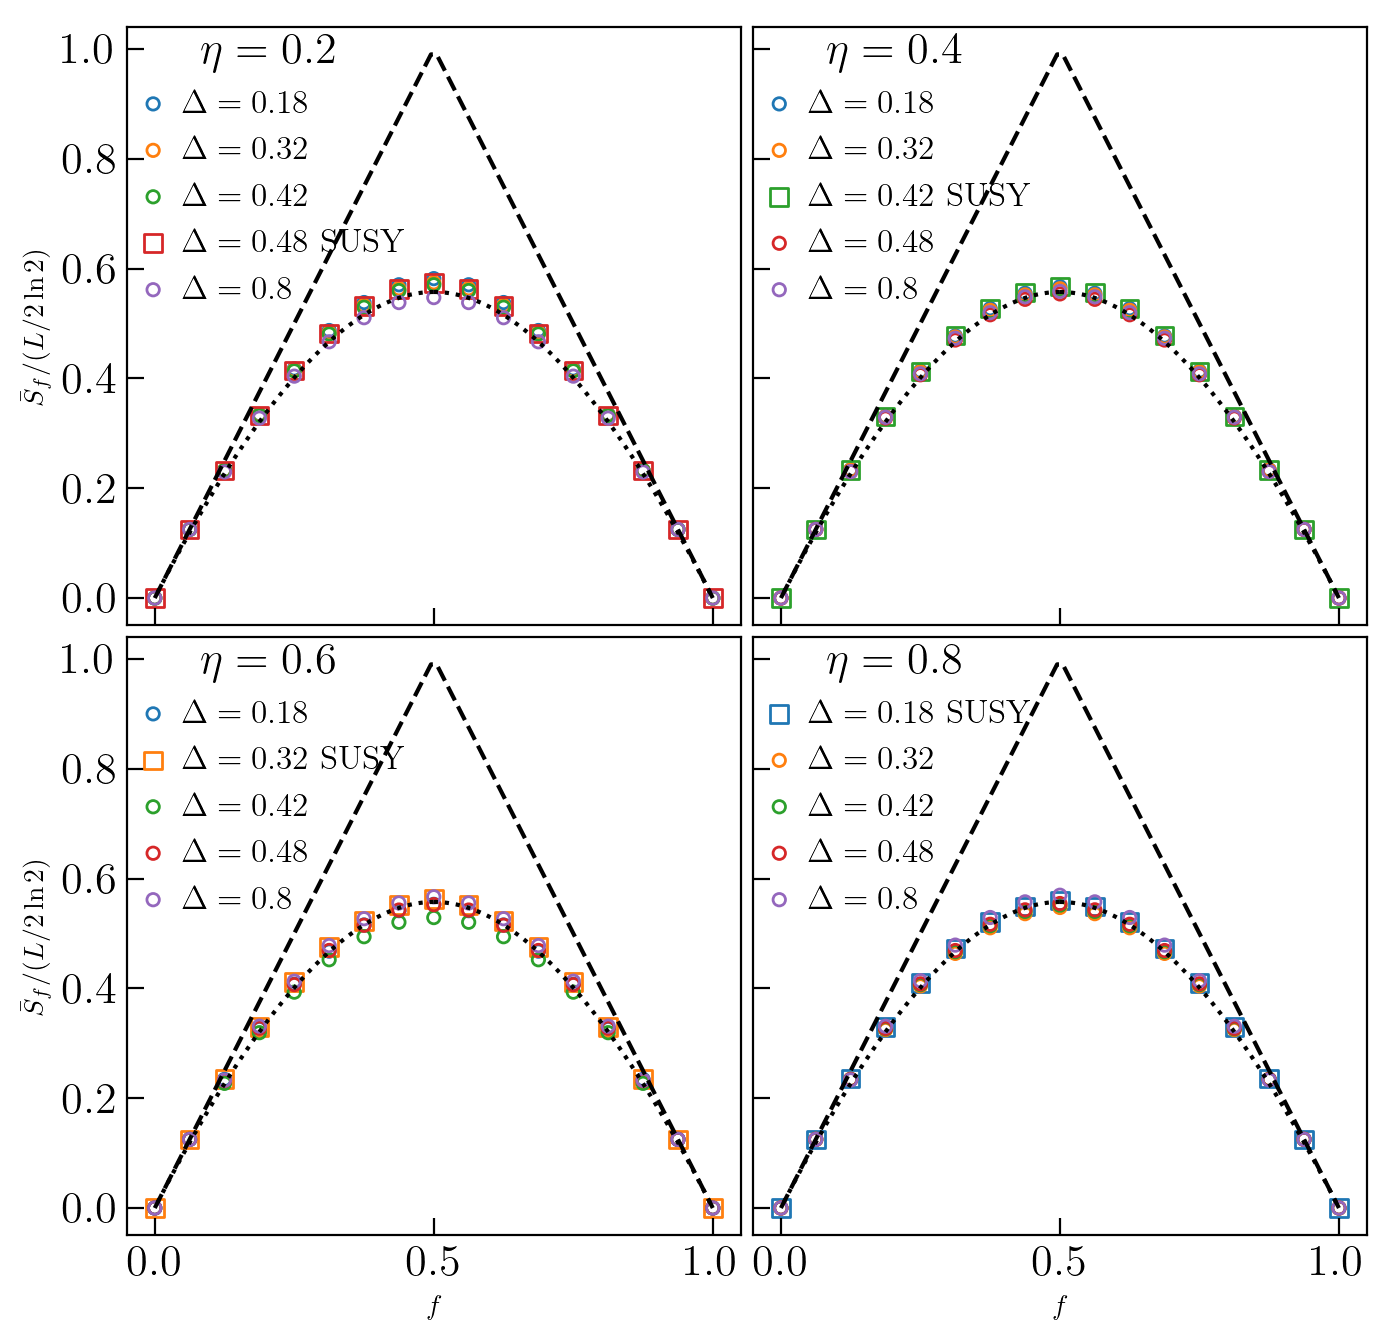

In [18]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.5
e1=0.3

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 2*dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(8,8), dpi = 200, sharey=True, sharex=True)
axis = np.array(axis).flatten()

# deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


real_sec, _ = get_sectors(L, hx, hz)

dim_tot = 2**L

subsystem_frac = np.linspace(0, 1, L+1)
print(subsystem_frac)
for jj, e1 in enumerate([0.2, 0.4, 0.6, 0.8]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, d1 in enumerate([0.18, 0.32, 0.42, 0.48, 0.8]):
        
        entropy_ave = np.zeros((L+1))

        for LA in range(L//2 + 1):
            dim_tot = 0
            for [ks, ps, zxs, zzs] in real_sec:
                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('energies')[0])
                        entropies = np.array(file.get('entropy'))[LA]
                        dim = energies.size
                        dim_tot += dim

                        num = frac(dim)

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2) 
                        if my_max >= dim: my_max = dim

                        sample = entropies
                        if my_min > 0 and my_max < dim:
                            sample = entropies[my_min : my_max]
                        entropy_ave[LA] += dim * np.mean(sample) / 2**L
                        if LA < L//2: entropy_ave[L - LA] += dim * np.mean(sample) / 2**L
                else:
                    print(name)
            if dim_tot != 2**L:
                print("waaaaaaa", dim_tot, 2**L)
                
        _app = " SUSY" if np.abs(d1 - 0.5*(1-e1**2)) < 1e-10 else ""
        mar = 's' if np.abs(d1 - 0.5*(1-e1**2)) < 1e-10 else 'o'
        si = 40 if np.abs(d1 - 0.5*(1-e1**2)) < 1e-10 else 20
        axis[jj].scatter(subsystem_frac, entropy_ave / (L/2*np.log(2)), label=f"$\Delta={d1}$" + _app, color = next(colors_ls_cyc), s=si, marker = mar, facecolor='None')

    legend = axis[jj].legend(frameon=False, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.04), title=f"$\eta={e1}$", title_fontsize=16)
    
    if jj     >  0: axis[jj].set_xlabel(r"$f$")
    if jj % 2 == 0: axis[jj].set_ylabel(r"$\bar{S}_f/(L/2\ln2)$")
    
    ff = np.linspace(0, 1, 100)
    axis[jj].plot(ff, 1 - 2*np.abs(0.5 - ff), ls='--', color='black')
    
    ff = np.linspace(0., .5, 100)
    axis[jj].plot(ff, 2 * ff * (1 - (1 + (1-ff)/ff * np.log(1-ff) ) / np.log(2)), ls=':', color='black')
    
    ff = np.linspace(.5, 1., 100)
    axis[jj].plot(ff, 2 * (1-ff) * (1 - (1 + ff/(1-ff) * np.log(ff) ) / np.log(2)), ls=':', color='black')
    
    axis[jj].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    axis[jj].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

fig.subplots_adjust(wspace = 0.02, hspace=0.02)

## EIGENSTATES

0.2
0.4
0.6
0.8
1.0


(-10.0, 10.0)

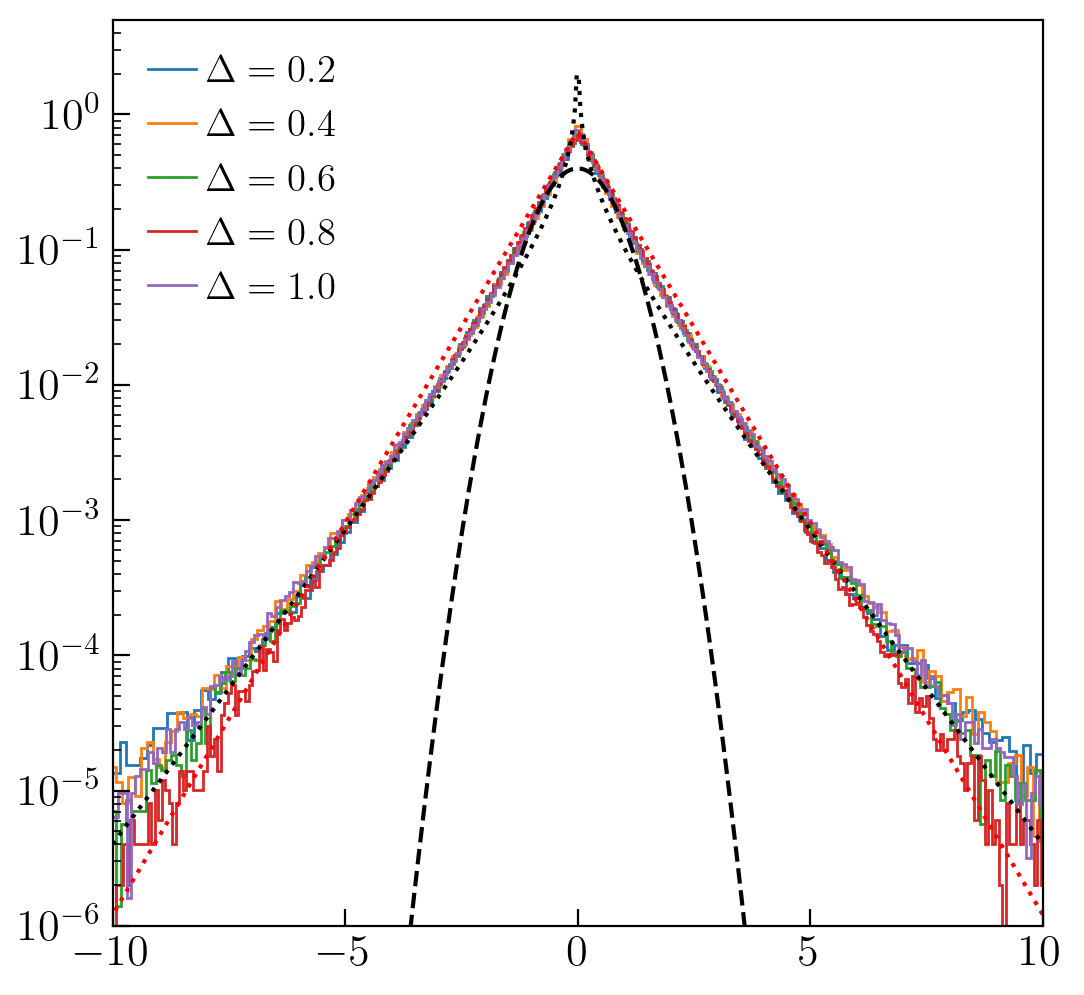

In [61]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.5
e1=0.2

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 0.25 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200, sharey=True)


real_sec, _ = get_sectors(L, hx, hz)

pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
colors_ls_cyc = itertools.cycle(colors_ls)
for ii, d1 in enumerate([0.2, 0.4, 0.6, 0.8, 1.0]):
    entropy = []
    energy = []
    states = []
    for [ks, ps, zxs, zzs] in real_sec:
        name = dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                entropies = np.array(file.get('entropy'))[LA]
                dim = energies.size
                V = np.array(file.get('eigenvectors'))
                V = V.flatten()
                
                V = (V / np.std(V))
                energies /= np.std(energies)
                
                energy = [*energy, *energies]
                entropy = [*entropy, *entropies]
                states = [*states, *V]
        else:
            print(name)
    print(d1)
    bins, hist = np.histogram(states, bins=300, normed=True)
    axis.stairs(bins, hist, label=f"$\Delta={d1}$", color = next(colors_ls_cyc))


legend = axis.legend(frameon=False, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.00,1.00))
en = np.linspace(-20, 20, 1000)
axis.plot(en, 1/np.sqrt(2*np.pi) * np.exp(-en**2), ls='--', color='black')
axis.plot(en, 1/np.sqrt(np.abs(4*np.pi*en)) * np.exp(-np.abs(en)), ls=':', color='black')
axis.plot(en, 3/4*np.exp(-4/3 * np.abs(en)), ls=':', color='red')

axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_xscale('log');
axis.set_yscale('log')
axis.set_ylim(1e-6, 5e0)
axis.set_xlim(-10, 10)

# SIZE SCALING

In [ ]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.2
e1=0.3
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 2 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=3, ncols=3, figsize=(12,8), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

# deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)



pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L

#print(subsystem_frac)
for jj, e1 in enumerate([0.2, 0.4, 0.6]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, d1 in enumerate([0.2]):
        
        for L in np.arange(14,22,1):
            
            entropy_ave = np.zeros((L//2 + L%2))
            subsystem_frac = np.linspace(0, 0.5, L // 2 + L%2)
            real_sec, imag_sec = get_sectors(L, hx, hz)

            for LA in range(L//2 + L%2):
                dim_tot = 0
                for [ks, ps, zxs, zzs] in real_sec + imag_sec:
                    name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                    if exists(name):
                        with h5py.File(name, "r") as file:
                            energies = np.array(file.get('energies')[0])
                            entropies = np.array(file.get('entropy'))[LA]
                            dim = energies.size
                            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                            num = frac(dim)

                            E_av = np.mean(energies)
                            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                            
                            my_min = int(index_meanE - num / 2)
                            if my_min < 0: my_min = 0;  

                            my_max = int(index_meanE + num / 2) 
                            if my_max >= dim: my_max = dim

                            sample = entropies
                            if my_min > 0 and my_max < dim:
                                sample = entropies[my_min : my_max]
                            entropy_ave[LA] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
                            #if LA < L//2: entropy_ave[L - LA] += dim * np.mean(sample) / 2**L
                    else:
                        print(name)
                if dim_tot != 2**L:
                    print("waaaaaaa", dim_tot, 2**L)
                
                entropy_ave[LA] /= dim_tot   
                
            axis[ii][jj].scatter(subsystem_frac, entropy_ave / (L/2*np.log(2) - 0.5), label=f"$L={L}$", color = next(colors_ls_cyc), s=20, facecolor='None')

        if ii == 0 and jj == 0:
            legend = axis[ii][jj].legend(frameon=False, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.04))
            legend.set_title(f"$\eta={e1}$")
        
        axis[ii][jj].set_xlabel(r"$f$", fontsize=14)
        if jj % 2 == 0: axis[ii][jj].set_ylabel(r"$\bar{S}_f/(L/2\ln2)$", fontsize=14)
        
        ff = np.linspace(0, 0.5, 100)
        axis[ii][jj].plot(ff, 1 - 2*np.abs(0.5 - ff), ls='--', color='black')
        
        ff = np.linspace(0., 0.5, 100)
        axis[ii][jj].plot(ff, 2 * ff * (1 - (1 + (1-ff)/ff * np.log(1-ff) ) / np.log(2)), ls=':', color='black')
        
        #ff = np.linspace(.5, 1., 100)
        #axis[ii][jj].plot(ff, 2 * (1-ff) * (1 - (1 + ff/(1-ff) * np.log(ff) ) / np.log(2)), ls=':', color='black')
        
        axis[ii][jj].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
        axis[ii][jj].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

fig.subplots_adjust(wspace = 0.02, hspace=0.02)

0 -1 -1 -1 1
0 -1 -1 1 1
0 -1 1 -1 1
0 -1 1 1 1
0 1 -1 -1 1
0 1 -1 1 1
0 1 1 -1 1
0 1 1 1 1
11 -1 -1 -1 1
11 -1 -1 1 1
11 -1 1 -1 1
11 -1 1 1 1
11 1 -1 -1 1
11 1 -1 1 1
11 1 1 -1 1
11 1 1 1 1
[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5

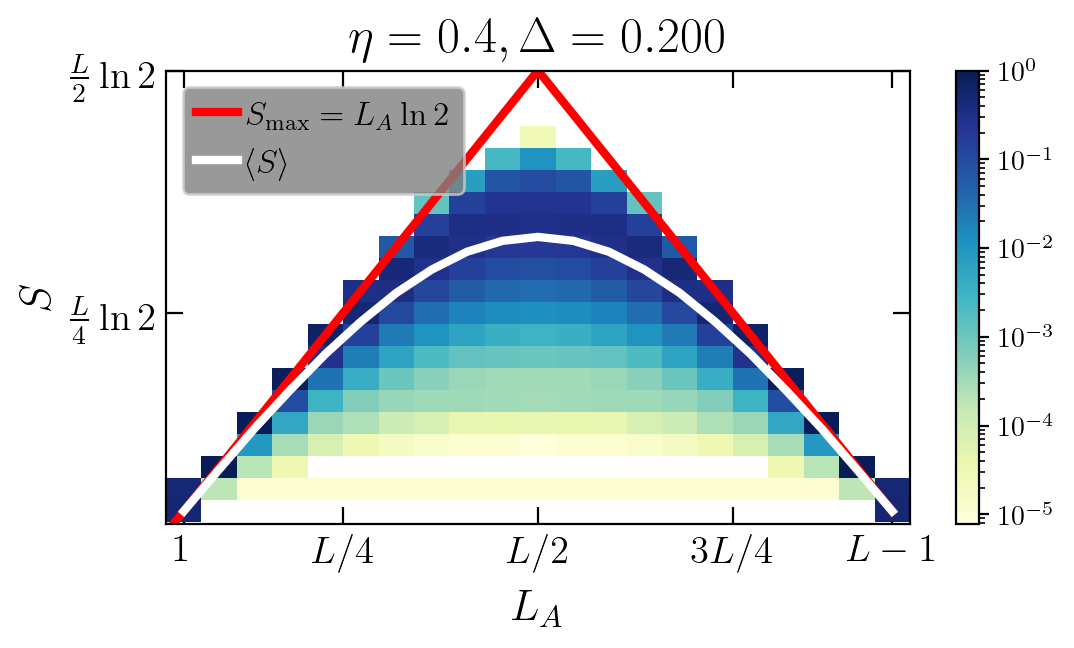

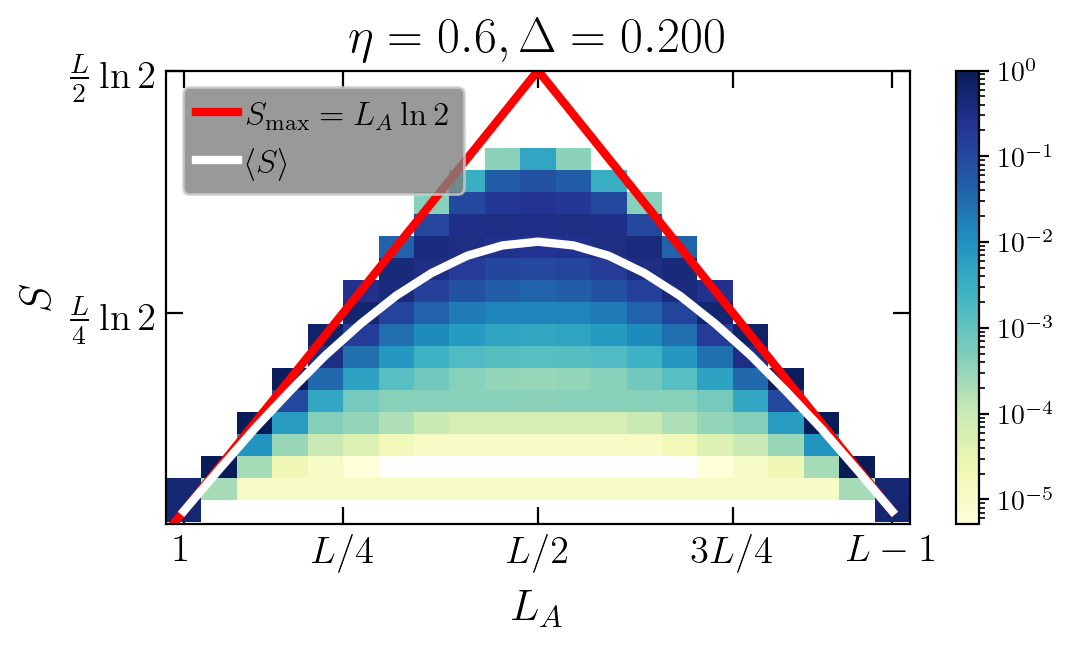

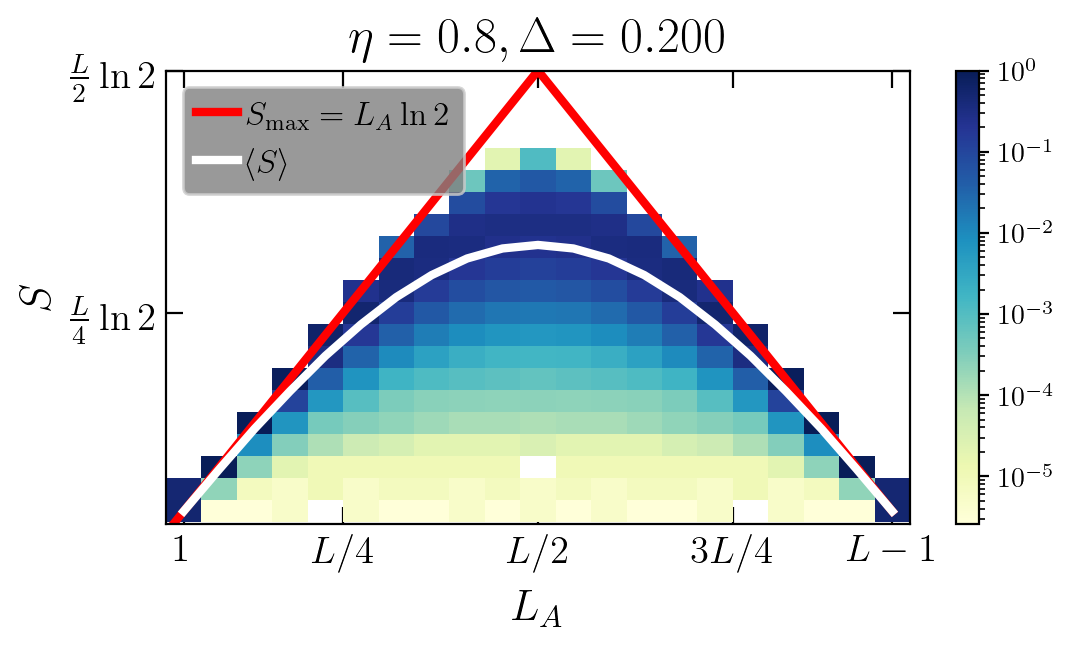

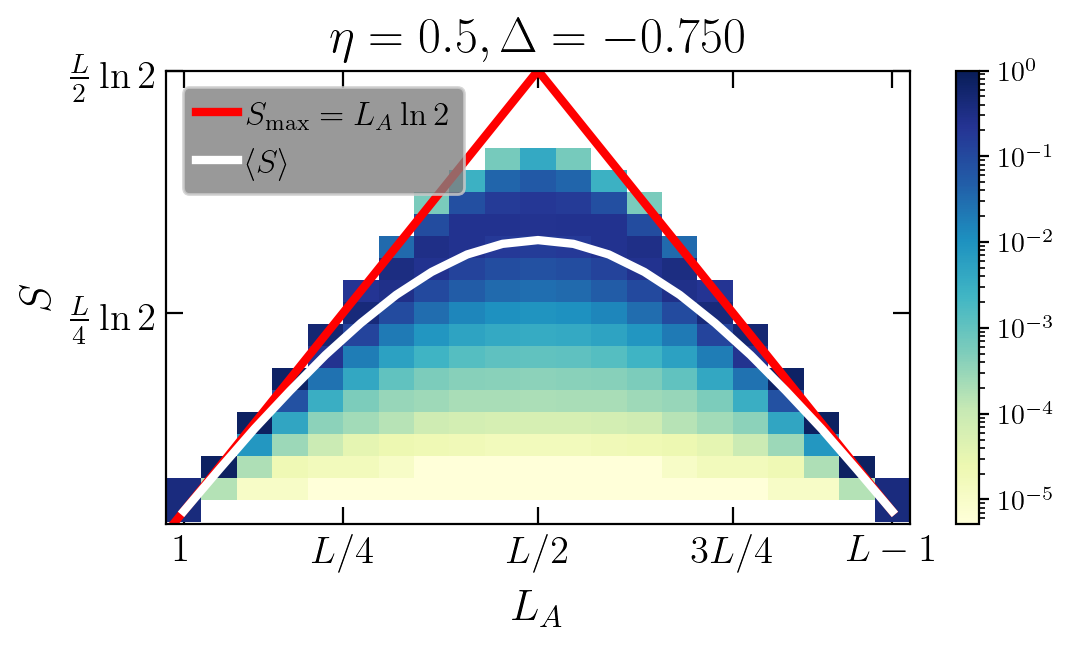

In [70]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=0.2
e1=0.2



real_sec, imag_sec = get_sectors(L, 0, 0)

sects = real_sec #+ imag_sec if BOUNDARY_COND == 'PBC' else real_sec


def plot_nice_heatmap(d1, e1):
    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,3), dpi = 200)

    entrop = np.arange(0, 2*(L//2 + L%2) + 1)/2
    entrop = np.linspace(0, L * np.log(2)/2, L + 1)

    sub_sizes = np.arange(1, L)
    density = np.zeros((sub_sizes.size, entrop.size - 1))

    average_entropy = np.zeros((sub_sizes.size))
    dim_tot = 0
    for [ks, ps, zxs, zzs] in sects:
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                dim = energies.size

                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] == 1]
                print(ks, ps, zxs, zzs, max(counts))
                # if len(non_deg_idx) < dim:
                #     print(ks, ps, zxs, zzs, counts[counts > 1])

                dim_tot += (2 if ks == 0 or ks == L / 2 else 1) * dim
                for LA in np.arange(1, (L//2 + L%2) + 1):
                    if LA > L//2:   entropies = np.array(file.get('entropy'))[L - LA][non_deg_idx]
                    else:           entropies = np.array(file.get('entropy'))[LA][non_deg_idx]

                    hist, bins = np.histogram(entropies, bins=entrop)
                    hist = np.array(hist)
                    #print(bins, hist)
                    #hist.resize( sub_sizes.size )

                    density[LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.array(hist) #* dim
                    average_entropy[LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.mean(entropies) * dim
                    if LA < L//2:
                        density[L - LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.array(hist) #* dim
                        average_entropy[L - LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.mean(entropies) * dim
                    #print(LA, ks, ps, zxs, zzs)
        else:
            print(name)

    density /= dim_tot
    average_entropy /= dim_tot

    #white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
    upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
    colors = np.vstack((upper))  

    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    X, Y = np.meshgrid(sub_sizes, entrop[1:])
    print(X, Y)
    p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, norm=matplotlib.colors.LogNorm(vmin=np.min(density[density > 0]), vmax=1.0))

    laa = np.arange(0, L//2 + L%2 + 1)
    axis.plot(laa, laa * np.log(2), c='red', lw=3)
    laa = np.arange(L//2, L)
    axis.plot(laa, (L - laa)*np.log(2), c='red', lw=3, label=r"$S_{\rm max}=L_A\ln2$")

    axis.plot(sub_sizes, average_entropy, lw=3, c='white', label=r"$\langle S\rangle$")
    axis.set_xlim(0.5, L-0.5)
    axis.set_ylim(0.5, L/2*np.log(2))

    fig_help.set_plot_elements(axis, ylabel="$S$", xlabel=r"$L_A$", font_size=14, set_legend=False)

    xticks = [1, L/4, L/2, 3*L/4, L-1]
    tick_labels = ["$1$", "$L/4$", "$L/2$", "$3L/4$", "$L-1$"]
    axis.set_xticks(xticks)
    axis.set_xticklabels(tick_labels)

    xticks = [L/4*np.log(2), L/2*np.log(2)]
    tick_labels = [r"$\frac{L}{4}\ln2$", r"$\frac{L}{2}\ln2$"]
    axis.set_yticks(xticks)
    axis.set_yticklabels(tick_labels)
    # axis.xaxis.set_minor_locator(plt.NullLocator())
    # axis.yaxis.set_minor_locator(plt.NullLocator())

    axis.set_title(r"$\eta=%.1f,\Delta=%.3f$"%(e1,d1), fontsize=18)
    legend = axis.legend(frameon=1, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
    fig.colorbar(p)

    plt.savefig(f"PLOTS/HeatMap_L={L},d1={d1},e1={e1}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    plt.savefig(f"PLOTS/HeatMap_L={L},d1={d1},e1={e1}.png", bbox_inches = 'tight', pad_inches=0.02)


plot_nice_heatmap(d1=0.2, e1=0.4)
plot_nice_heatmap(d1=0.2, e1=0.6)
plot_nice_heatmap(d1=0.2, e1=0.8)
plot_nice_heatmap(d1=-0.75, e1=0.5)
plt.show()

16 0 -1 -1 -1 4
16 0 -1 -1 1 4
16 0 -1 1 -1 4
16 0 -1 1 1 4
16 0 1 -1 -1 4
16 0 1 -1 1 4
16 0 1 1 -1 4
16 0 1 1 1 4
16 8 -1 -1 -1 4
16 8 -1 -1 1 4
16 8 -1 1 -1 4
16 8 -1 1 1 4
16 8 1 -1 -1 4
16 8 1 -1 1 4
16 8 1 1 -1 4
16 8 1 1 1 4
16 1 1 -1 -1 4
16 1 1 -1 1 4
16 1 1 1 -1 4
16 1 1 1 1 4
16 2 1 -1 -1 4
16 2 1 -1 1 4
16 2 1 1 -1 4
16 2 1 1 1 4
16 3 1 -1 -1 4
16 3 1 -1 1 4
16 3 1 1 -1 4
16 3 1 1 1 4
16 4 1 -1 -1 4
16 4 1 -1 1 4
16 4 1 1 -1 4
16 4 1 1 1 4
16 5 1 -1 -1 4
16 5 1 -1 1 4
16 5 1 1 -1 4
16 5 1 1 1 4
16 6 1 -1 -1 4
16 6 1 -1 1 4
16 6 1 1 -1 4
16 6 1 1 1 4
16 7 1 -1 -1 4
16 7 1 -1 1 4
16 7 1 1 -1 4
16 7 1 1 1 4
18 0 -1 -1 -1 9
18 0 -1 -1 1 4
18 0 -1 1 -1 6
18 0 -1 1 1 6
18 0 1 -1 -1 4
18 0 1 -1 1 9
18 0 1 1 -1 7
18 0 1 1 1 9
18 9 -1 -1 -1 4
18 9 -1 -1 1 4
18 9 -1 1 -1 4
18 9 -1 1 1 4
18 9 1 -1 -1 4
18 9 1 -1 1 4
18 9 1 1 -1 4
18 9 1 1 1 4
18 1 1 -1 -1 4
18 1 1 -1 1 4
18 1 1 1 -1 4
18 1 1 1 1 4
18 2 1 -1 -1 4
18 2 1 -1 1 4
18 2 1 1 -1 4
18 2 1 1 1 4
18 3 1 -1 -1 4
18 3 1 -1 1 4
18 

Text(0.5, 1.0, '$\\eta=0.5,\\Delta=-0.375,L_A=2$')

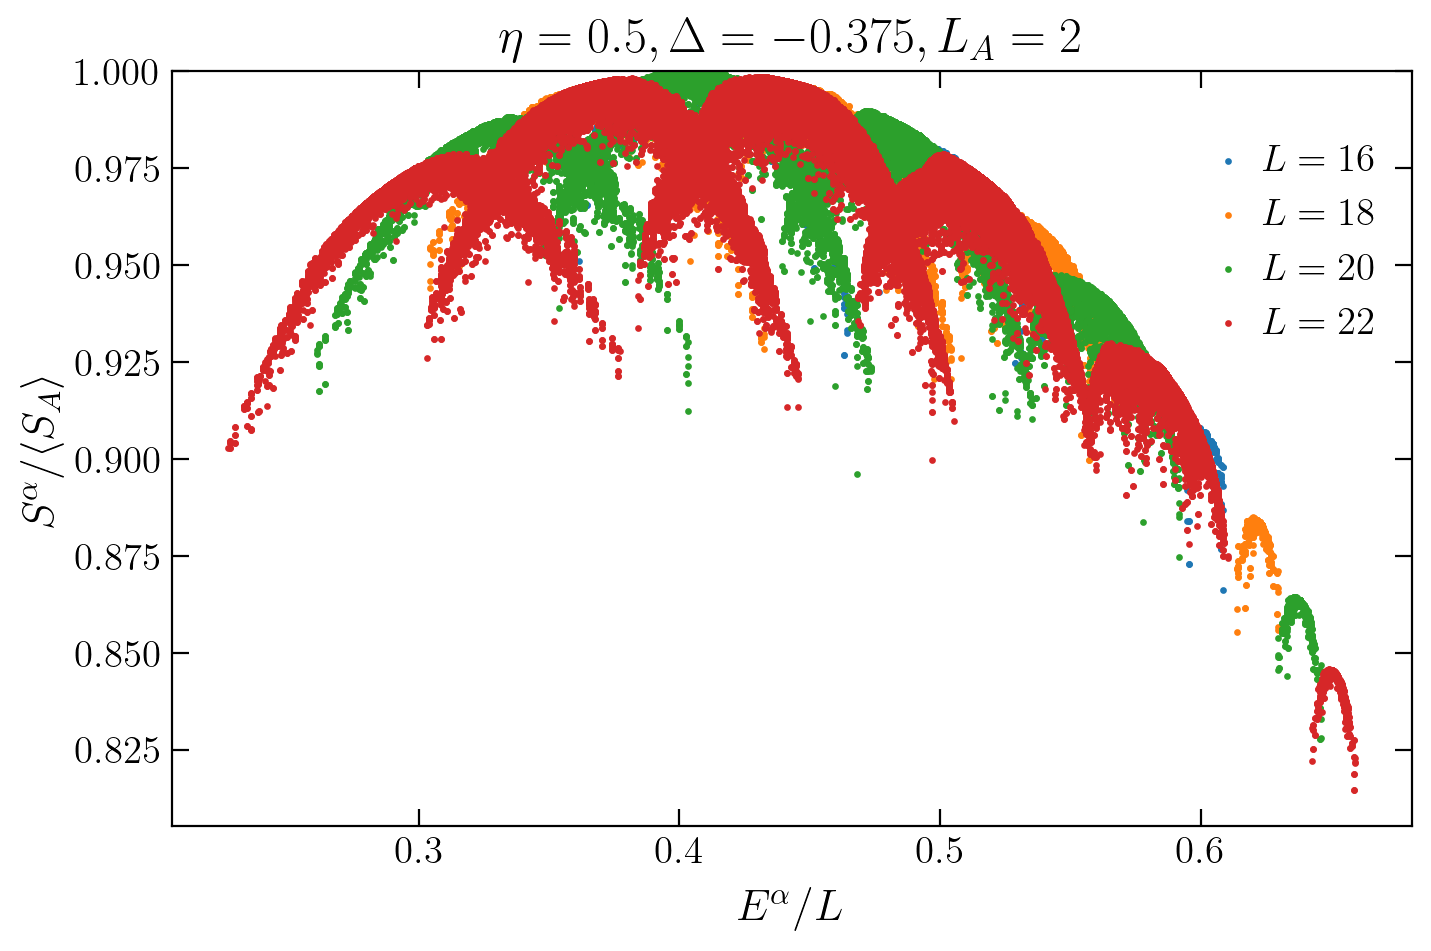

In [180]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=-0.375
e1=0.5


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 200, sharex=True, sharey=True)
for L in np.arange(16, 24, 2):
    real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
    LA = 2
    dim_tot = 0
    E = []
    S = []
    for [ks, ps, zxs, zzs] in sects:
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])

                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] > 1]
                print(L, ks, ps, zxs, zzs, max(counts))
                energies = energies[non_deg_idx]
                entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                E = [*E, *energies] if ks == 0 or ks == L / 2 else [*E, *energies, *energies]
                S = [*S, *entropies] if ks == 0 or ks == L / 2 else [*S, *entropies, *entropies]
        #print(L, e1, ks, ps, zxs, zzs)
    axis.scatter(E / L, S / page_result(LA, L - LA), s=2, rasterized=True, label=r"$L=%d$"%L)

fig_help.set_plot_elements(axis, ylabel=r"$S^\alpha/\langle S_A\rangle$", xlabel=r"$E^\alpha/L$", font_size=14, set_legend=False)
axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.0, 0.95))
axis.set_ylim(None, 1)
#axis.axhline(y=LA * np.log(2), ls='--', c='black')
axis.set_title(r"$\eta=%.1f,\Delta=%.3f,L_A=2$"%(e1,d1), fontsize=18)

# plt.savefig(f"PLOTS/EntropyDistribution_L_even,d1={d1},e1={e1},LA=L_2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig(f"PLOTS/EntropyDistribution_L_even,d1={d1},e1={e1},LA=L_2.png", bbox_inches = 'tight', pad_inches=0.02)

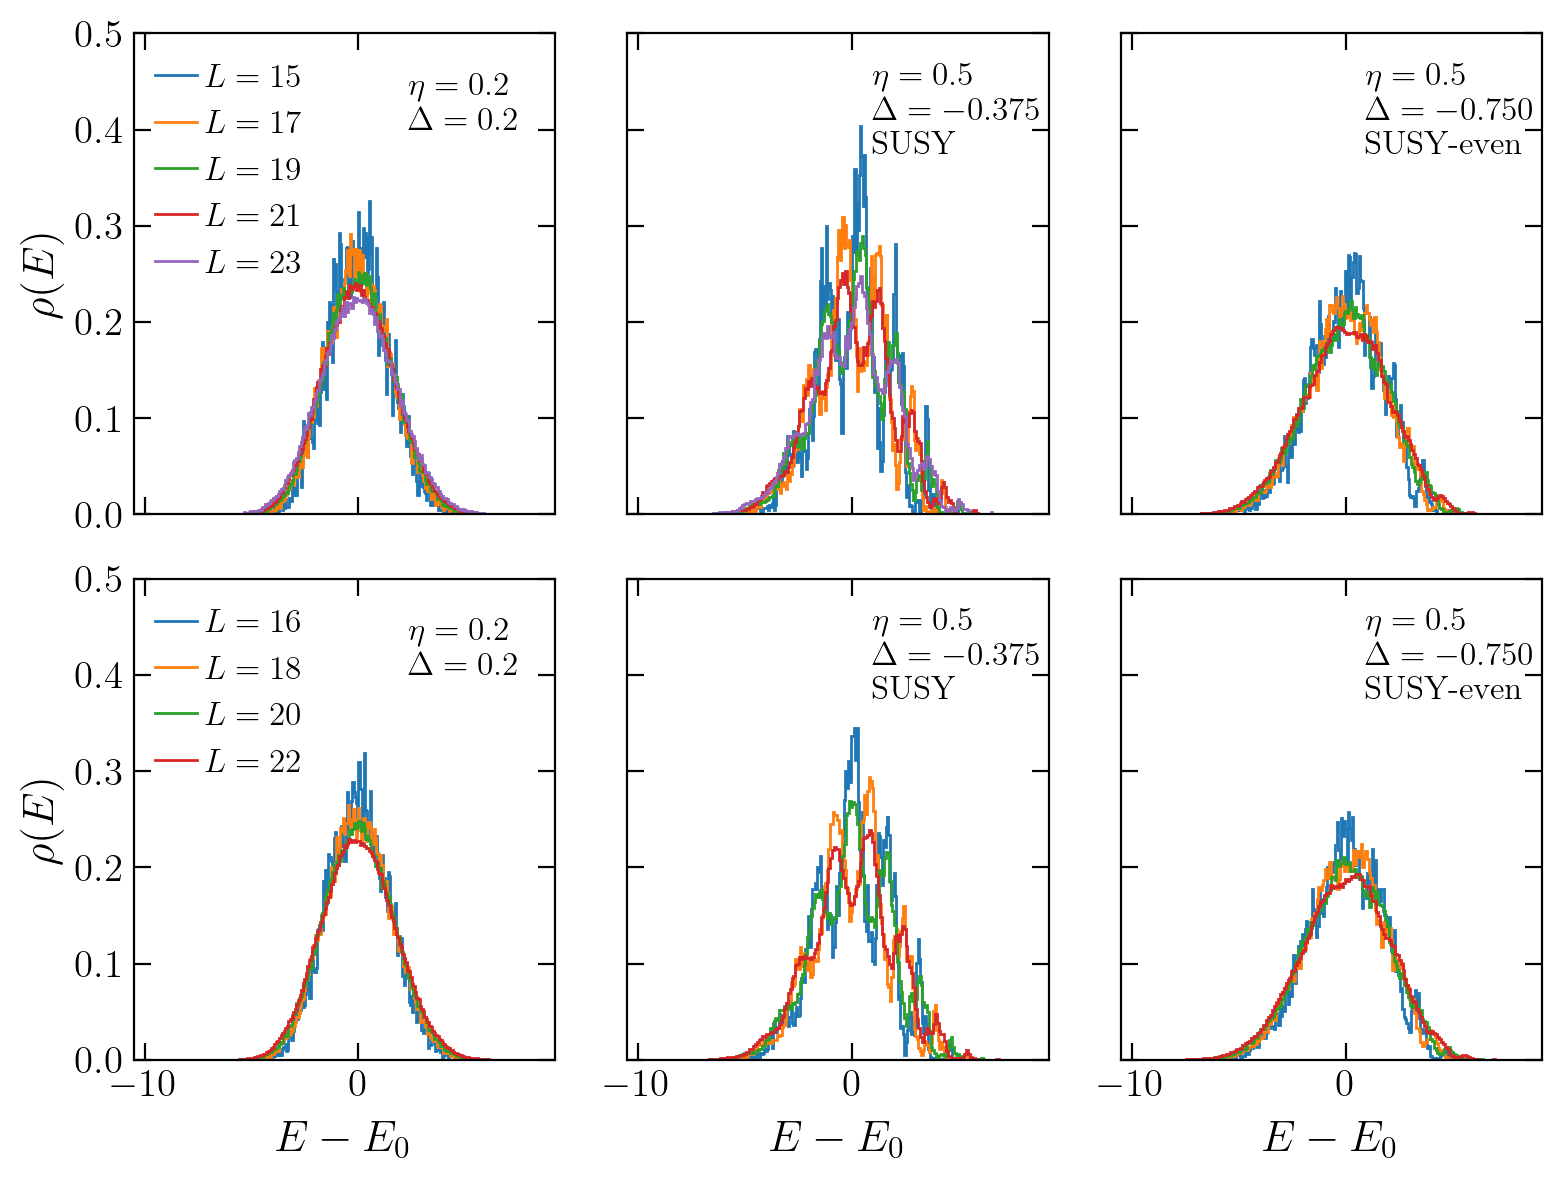

In [68]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=-0.375
e1=0.5

fig, axis = plt.subplots( nrows=2, ncols=3, figsize=(8,6), dpi = 200, sharey=True, sharex=True)
#axis = np.array(axis).flatten()

for ii, [d1, e1] in enumerate([ [0.2, 0.2], [0.-0.375, 0.5], [-0.75, 0.5]]):

    for jj, sizes in enumerate([np.arange(15, 24, 2), np.arange(16, 24, 2)]):
        for L in sizes:
            real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

            sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
            LA = L // 2
            dim_tot = 0
            E = []
            S = []
            for [ks, ps, zxs, zzs] in sects:
                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('energies')[0]) - L * (3+e1**2)/8
                        E = [*E, *energies] if ks == 0 or ks == L / 2 else [*E, *energies, *energies]

                #print(L, e1, ks, ps, zxs, zzs)
            hist, edges = np.histogram(E, bins=200, normed=True)
            axis[jj][ii].stairs(hist, edges, label=r"$L=%d$"%L)
        
        fig_help.set_plot_elements(axis[jj][ii], ylabel=r"$\rho(E)$" if ii == 0 else "", xlabel=r"$E-E_0$" if jj > 0 else "", font_size=14, set_legend=False)
        if ii == 0:
            legend = axis[jj][ii].legend(frameon=0, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, 1.))
        #axis[ii].set_title(r"$\eta=%.1f,\Delta=%.3f$"%(e1,d1), fontsize=18)
        axis[jj][ii].annotate(r"$\eta=%.1f$"%e1 + f"\n" + (r"$\Delta=%.1f$"%(d1) if ii == 0 else r"$\Delta=%.3f$"%(d1)) + ("\nSUSY" if ii == 1 else ("\nSUSY-even" if ii == 2 else "")), 
                                    xy=(0.65, 0.8) if ii == 0 else (0.58, 0.75), fontsize=12, xycoords='axes fraction')

axis[0][0].set_ylim(0, 0.5)

fig.tight_layout()
plt.savefig(f"PLOTS/DOS_all.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig(f"PLOTS/DOS_all.png", bbox_inches = 'tight', pad_inches=0.02)

[0.02, 0.1, 0.7]
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=3,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=1,zz=-1,edge=0.hdf5
waaaaaaa 3717586 4194304
[14 16 18 20 22] [3.05040405 3.43809006 3.82455445 4.20611212 4.59410335]
22 0.2 0.2 [0.62968035 0.55643177]
22 0.2 0.2 [0.53822726 0.4422981 ]
22 0.2 0.2 [2.16837262 0.54596371]
22 0.2 0.2 [1.04220101 0.42153824]
[14 16 18 20 22] [2.97338151 3.34083552 3.70577126 4.06851168 4.42993121]
22 -0.375 0.5 [0.68668098 0.52577089]
22 -0.375 0.5 [0.587

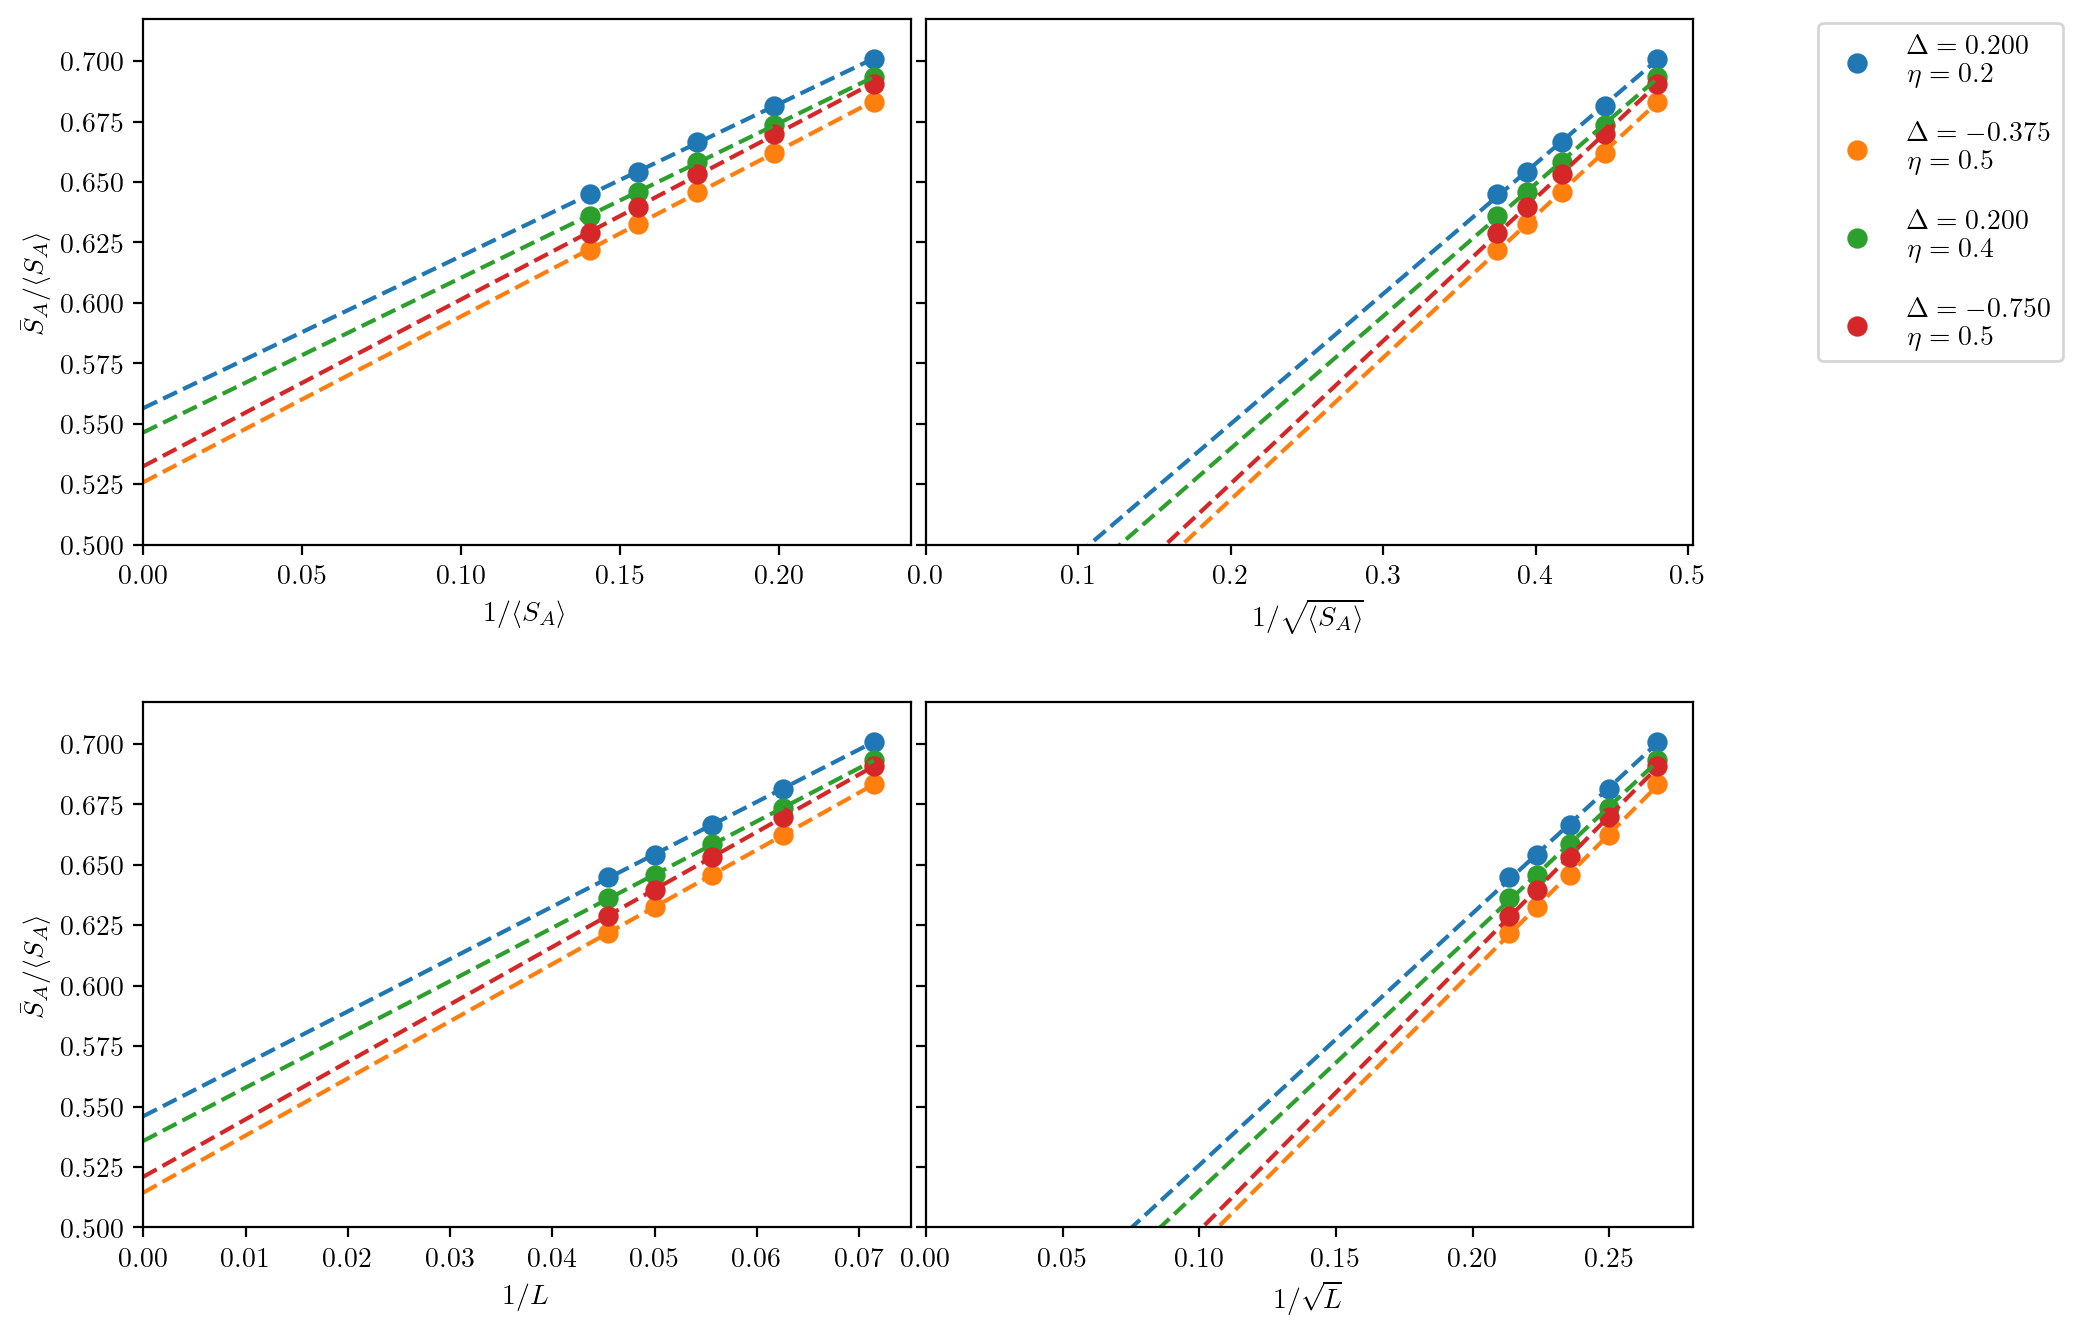

In [197]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

L=16

J1=1.0
d1=0.2
e1=0.2
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1


frac = lambda dim: 2 * dim


fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 24, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

colors = {0.2: 'blue', 0.4: 'green', 0.6: 'purple'}
#for e1 in [0.2, 0.4, 0.6]:
#for d1 in [-0.375, -0.75]:
for [d1, e1] in [[0.2, 0.2], [-0.375, 0.5], [0.2, 0.4], [-0.75, 0.5]]:
    col = next(colors_ls_cyc)

    sizes = sizes_even
    entropy= np.zeros((sizes.size))
    
    LAA = np.ones((sizes.size)).astype(int)
    LAA = sizes // 2
    for ii, L in enumerate(sizes):
        
        real_sec, imag_sec = get_sectors(L, hx, hz)

        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
        LA = LAA[ii]
        dim_tot = 0
        for [ks, ps, zxs, zzs] in sects:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])

                    _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                    non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] == 1]

                    entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                    
                    dim = energies.size
                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropies
                    if my_min > 0 and my_max < dim:
                        sample = entropies[my_min : my_max]
                    
                    entropy[ii] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
            else:
                print(name)
        if dim_tot != 2**L:
            print("waaaaaaa", dim_tot, 2**L)
        
        if dim_tot > 0 : entropy[ii] /= dim_tot    
    print(sizes_even, entropy)
    Spage = np.array(page_result( LAA, sizes - LAA))
    def plot_with_fit(ax, xx):

        yy = entropy / Spage

        pars, pconv = fit(lin_fit2,
                        xdata = xx,
                        ydata = yy)
        print(L, d1, e1, pars)
        xval = np.linspace(0, xx[0], 100)
        ax.plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
        ax.scatter(xx, yy, marker='o', s=40, edgecolor = col, label=r"$\Delta=%.3f$"%(d1) + f"\n" + r"$\eta=%.1f$"%(e1))

    
    xx = 1.0 / Spage
    plot_with_fit(axis[0][0], xx)

    xx = 1.0 / np.sqrt(Spage)
    plot_with_fit(axis[0][1], xx)

    xx = 1.0 / sizes
    plot_with_fit(axis[1][0], xx)

    xx = 1.0 / np.sqrt(sizes)
    plot_with_fit(axis[1][1], xx)

for ax in np.array(axis).flatten():
    ax.set_xlim(0, None)
    ax.set_ylim(0.5, None)

axis[0][0].set_ylabel(r"$\bar S_A / \langle S_A\rangle$")
axis[0][0].set_xlabel(r"$1 / \langle S_A\rangle$")
axis[0][1].set_xlabel(r"$1 / \sqrt{\langle S_A\rangle}$")
axis[0][1].legend(loc='upper right', bbox_to_anchor=(1.5,1.02), labelspacing=1.25)

axis[1][0].set_ylabel(r"$\bar S_A / \langle S_A\rangle$")
axis[1][0].set_xlabel(r"$ 1 / L$")
axis[1][1].set_xlabel(r"$ 1 / \sqrt{L}$")
fig.subplots_adjust(wspace = 0.02, hspace=0.3)

[0.02, 0.1, 0.7]
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=3,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=1,zz=-1,edge=0.hdf5
waaaaaaa 3717586 4194304
[16 18 20 22] [3.43809006 3.82455445 4.20611212 4.59410335]
22 0.2 0.2 [0.63664405 0.55532013]
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.4,e2=0,hx=0,hz=0,k=1,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.4,e2=0,hx=0,hz=0,k=2,zx=-1,zz=-1,edge=0.hdf5
../resu

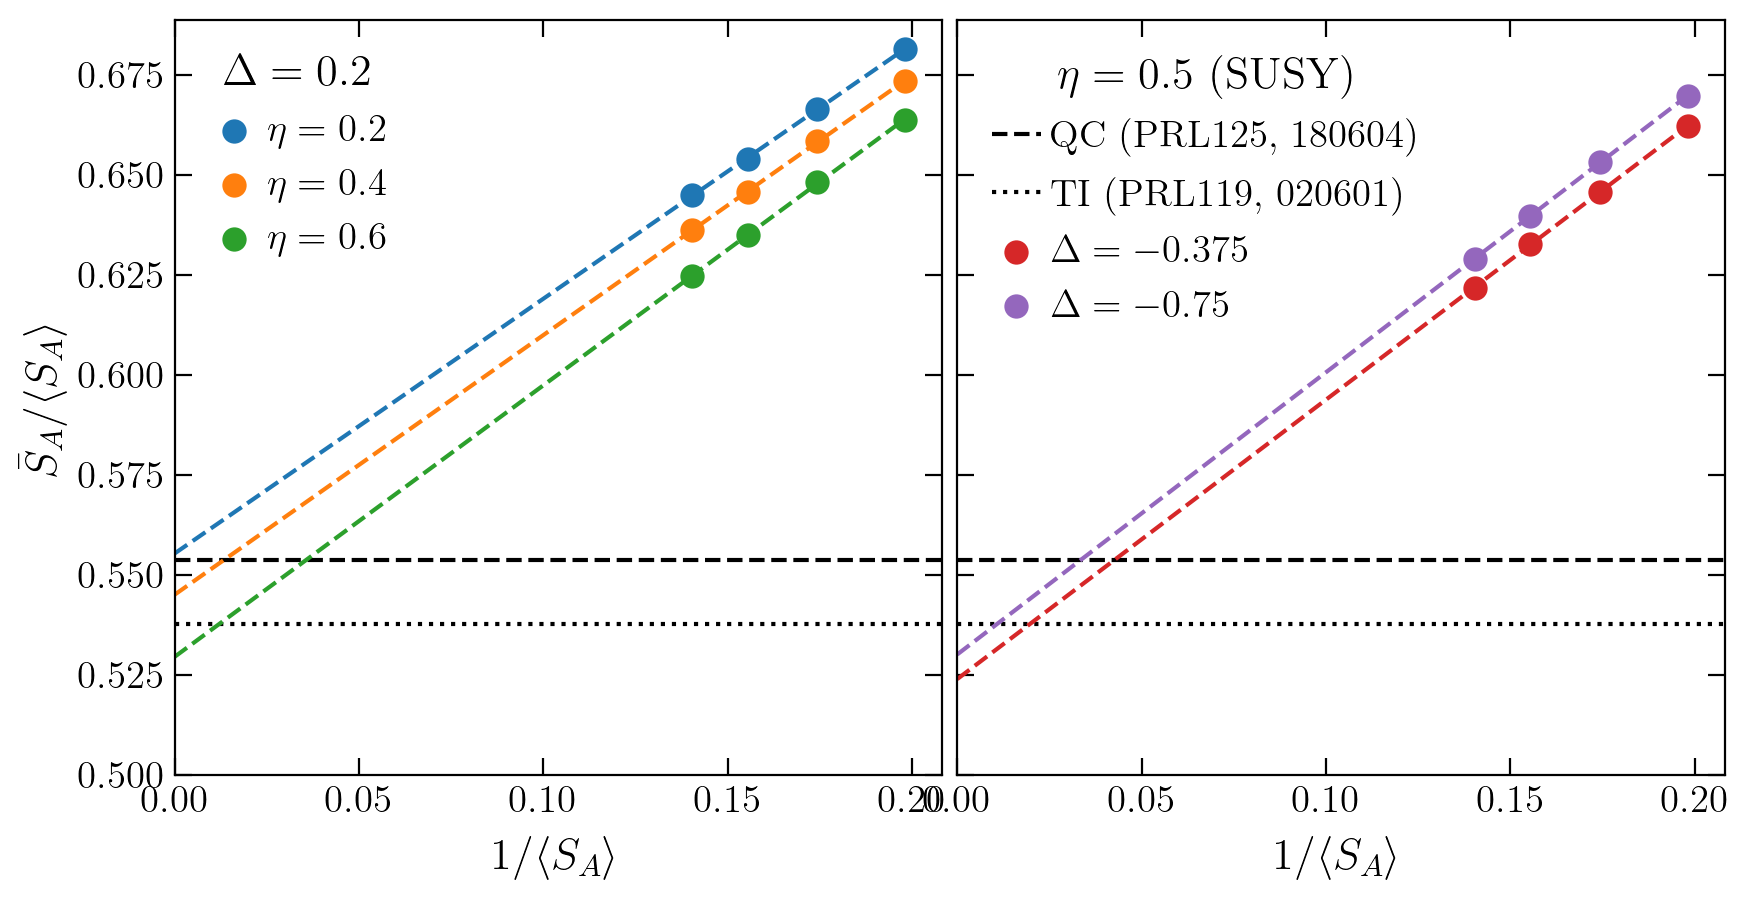

In [36]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

L=16

J1=1.0
d1=0.2
e1=0.2
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1


frac = lambda dim: dim+1


fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(16, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

colors = {0.2: 'blue', 0.4: 'green', 0.6: 'purple'}
#for e1 in [0.2, 0.4, 0.6]:
#for d1 in [-0.375, -0.75]:
def plottt(axis, d1, e1, label = ""):
    col = next(colors_ls_cyc)
    
    sizes = sizes_even

    entropy= np.zeros((sizes.size))
    
    LAA = np.ones((sizes.size)).astype(int)

    LAA = (sizes // 2).astype(int)
    for ii, L in enumerate(sizes):
    
        real_sec, imag_sec = get_sectors(L, hx, hz)

        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
        LA = LAA[ii]
        dim_tot = 0
        for [ks, ps, zxs, zzs] in sects:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])

                    _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                    non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] == 1]

                    entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                    
                    dim = energies.size
                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropies
                    if num < dim and my_min > 0 and my_max < dim:
                        sample = entropies[my_min : my_max]
                    
                    entropy[ii] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
            else:
                print(name)
        if dim_tot != 2**L:
            print("waaaaaaa", dim_tot, 2**L)
        
        if dim_tot > 0 : entropy[ii] /= dim_tot    
        
    print(sizes_even, entropy)
    Spage = np.array(page_result( LAA, sizes - LAA))
    xx = 1.0 / (sizes * np.log(2) / 2 - 0.5)#Spage

    yy = entropy / Spage

    pars, pconv = fit(lin_fit2,
                    xdata = xx,
                    ydata = yy)
    print(L, d1, e1, pars)
    xval = np.linspace(0, xx[0], 100)
    axis.plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
    axis.scatter(xx, yy, marker='o', s=60, color = col, label=label)
      

    axis.set_xlim(0, None)
    axis.set_ylim(0.5, None)
axis[0].axhline(y=0.5537, ls='--', c='black')
axis[0].axhline(y=0.5378, ls=':', c='black')
axis[1].axhline(y=0.5537, ls='--', c='black', label='QC (PRL125, 180604)')
axis[1].axhline(y=0.5378, ls=':', c='black', label='TI (PRL119, 020601)')
      
#[[0.2, 0.2], [-0.375, 0.5], [0.2, 0.4], [-0.75, 0.5]]
plottt(axis[0], d1=0.2, e1=0.2, label = r"$\eta=0.2$")
plottt(axis[0], d1=0.2, e1=0.4, label = r"$\eta=0.4$")
plottt(axis[0], d1=0.2, e1=0.6, label = r"$\eta=0.6$")
plottt(axis[1], d1=-0.375, e1=0.5, label = r"$\Delta=-0.375$")
plottt(axis[1], d1=-0.75, e1=0.5, label = r"$\Delta=-0.75$")

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar S_A / \langle S_A\rangle$", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title=r"$\Delta=0.2$", title_fontsize=16)

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[1].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title=r"$\eta=0.5$ (SUSY)", title_fontsize=16)

fig.subplots_adjust(wspace = 0.02, hspace=0.3)

[0.02, 0.1, 0.7]
[14 16 18 20 22] [2.97338151 3.34083552 3.70577126 4.06851168 4.42993121]
22 -0.375 0.5 [0.68072974 0.52699185]
[14 16 18 20 22] [3.07550779 3.48284266 3.88647377 4.28090137 4.66314941]
22 -0.375 0.5 [0.54950433 0.58088222]
[14 16 18 20 22] [2.9745774  3.34463477 3.71431608 4.08382208 4.45264566]
22 -0.375 0.5 [0.65296536 0.53347573]
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.75,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=2,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.75,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=9,zx=1,zz=1,edge=0.hdf5
waaaaaaa 4003654 4194304
[14 16 18 20 22] [3.00580634 3.37881534 3.74831702 4.11419023 4.48120521]
22 -0.75 0.5 [0.68495566 0.53356507]
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.75,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=2,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.75,d2=0,e1=0.5,e2=0,hx=0,hz=0,k=9,zx=1,zz=1,edge=0.hdf5
waaaaaaa 4003654 41

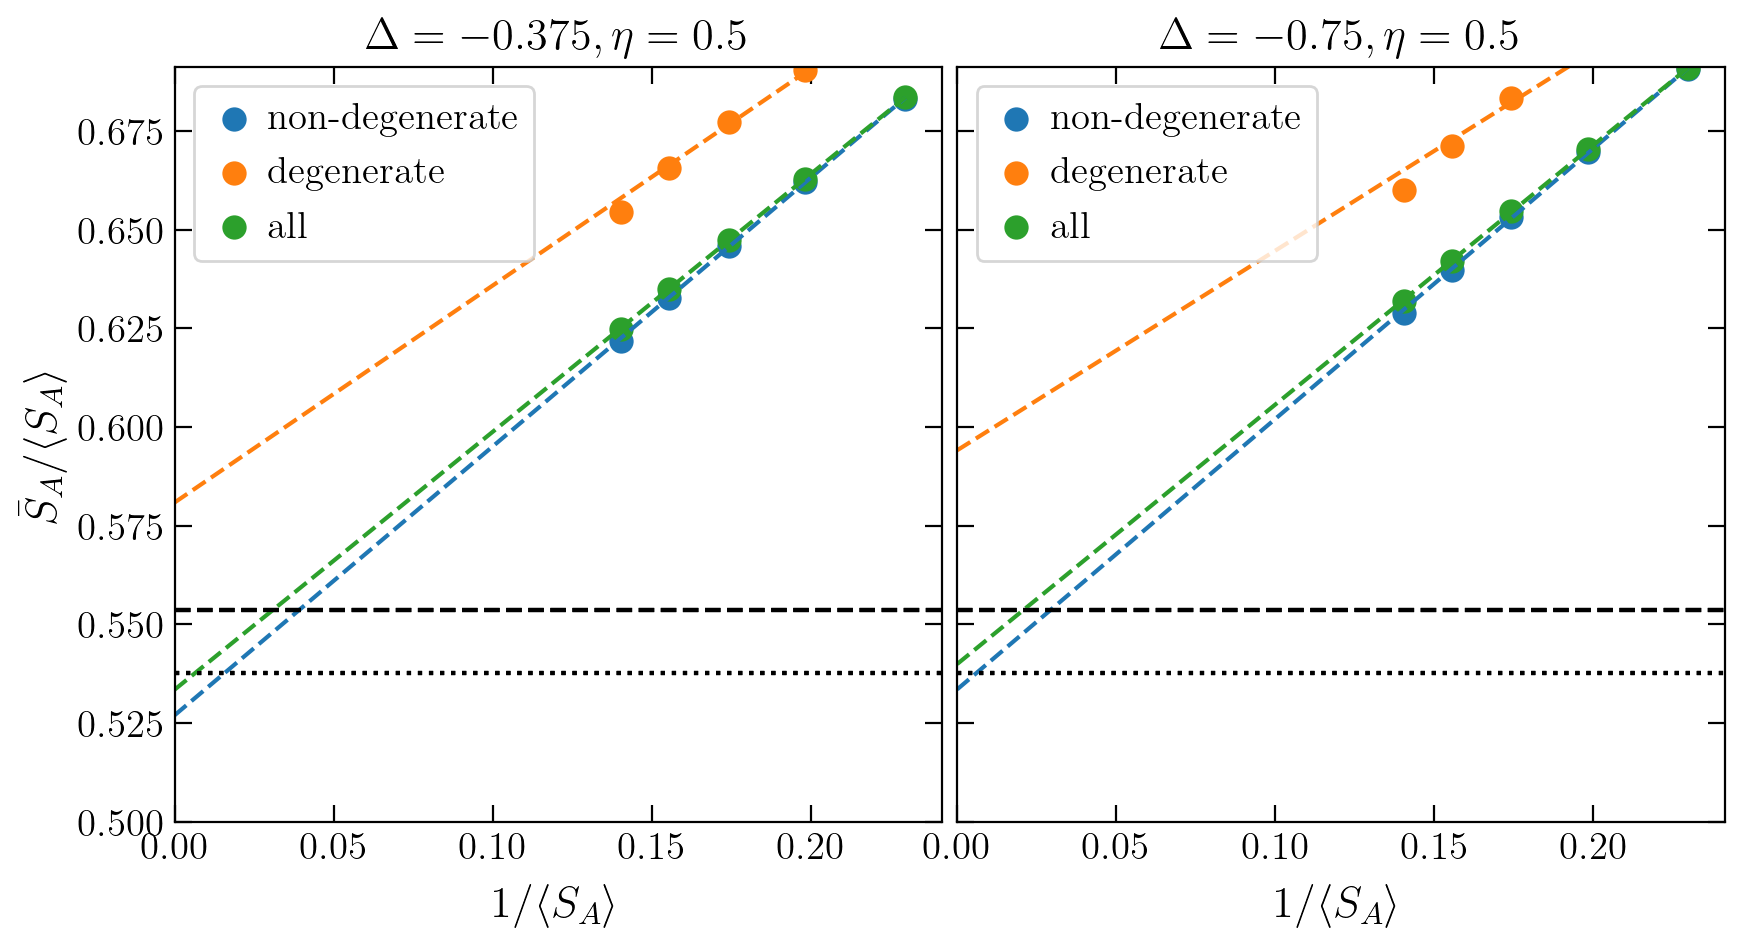

In [6]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

L=16

J1=1.0
d1=0.2
e1=0.2
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1


frac = lambda dim: 2*dim


fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)


pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

colors = {0.2: 'blue', 0.4: 'green', 0.6: 'purple'}
#for e1 in [0.2, 0.4, 0.6]:
#for d1 in [-0.375, -0.75]:
def plottt(axis, d1, e1, label = "", criterion = lambda x: x == 1):
    col = next(colors_ls_cyc)
    sizes = sizes_even
    entropy= np.zeros((sizes.size))
    
    LAA = np.ones((sizes.size)).astype(int)
    LAA = sizes // 2
    for ii, L in enumerate(sizes):
        
        real_sec, imag_sec = get_sectors(L, hx, hz)

        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
        LA = LAA[ii]
        dim_tot = 0
        for [ks, ps, zxs, zzs] in sects:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])

                    _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                    non_deg_idx = [idx for ii, idx in enumerate(indices) if criterion(counts[ii])]

                    entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                    
                    dim = energies.size
                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropies
                    if my_min > 0 and my_max < dim:
                        sample = entropies[my_min : my_max]
                    
                    entropy[ii] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
            else:
                print(name)
        if dim_tot != 2**L:
            print("waaaaaaa", dim_tot, 2**L)
        
        if dim_tot > 0 : entropy[ii] /= dim_tot   

    print(sizes_even, entropy)
    if not any( np.isnan(entropy) ):
        
        Spage = np.array(page_result( LAA, sizes - LAA))
        xx = 1.0 / Spage

        yy = entropy / Spage

        pars, pconv = fit(lin_fit2,
                        xdata = xx[:-1],
                        ydata = yy[:-1])
        print(L, d1, e1, pars)
        xval = np.linspace(0, xx[0], 100)
        axis.plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
        axis.scatter(xx, yy, marker='o', s=60, edgecolor = col, label=label)

    axis.axhline(y=0.5537, ls='--', c='black')
    axis.axhline(y=0.5378, ls=':', c='black')
            

    axis.set_xlim(0, None)
    axis.set_ylim(0.5, None)

plottt(axis[0], d1=-0.375, e1=0.5, label = "non-degenerate", criterion=lambda x: x == 1)
plottt(axis[0], d1=-0.375, e1=0.5, label = "degenerate", criterion=lambda x: x > 1)
plottt(axis[0], d1=-0.375, e1=0.5, label = "all", criterion=lambda x: x > 0)

colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[1], d1=-0.75, e1=0.5, label = "non-degenerate", criterion=lambda x: x == 1)
plottt(axis[1], d1=-0.75, e1=0.5, label = "degenerate", criterion=lambda x: x > 1)
plottt(axis[1], d1=-0.75, e1=0.5, label = "all", criterion=lambda x: x > 0)
axis[0].set_title(f"$\Delta={-0.375},\eta={0.5}$", fontsize=16)
axis[1].set_title(f"$\Delta={-0.75},\eta={0.5}$", fontsize=16)

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar S_A / \langle S_A\rangle$", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[0].legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title_fontsize=16)

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[1].legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title_fontsize=16)

fig.subplots_adjust(wspace = 0.02, hspace=0.3)

../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=3,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=4,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=10,zx=1,zz=-1,edge=0.hdf5
waaaaaaa 17200 4194304
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.4,e2=0,hx=0,hz=0,k=1,zx=1,zz=1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.4,e2=0,hx=0,hz=0,k=2,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=0.2,d2=0,e1=0.4,e2=0,hx=0,hz=0,k=6,zx=1,zz=-1,edge=0.hdf5

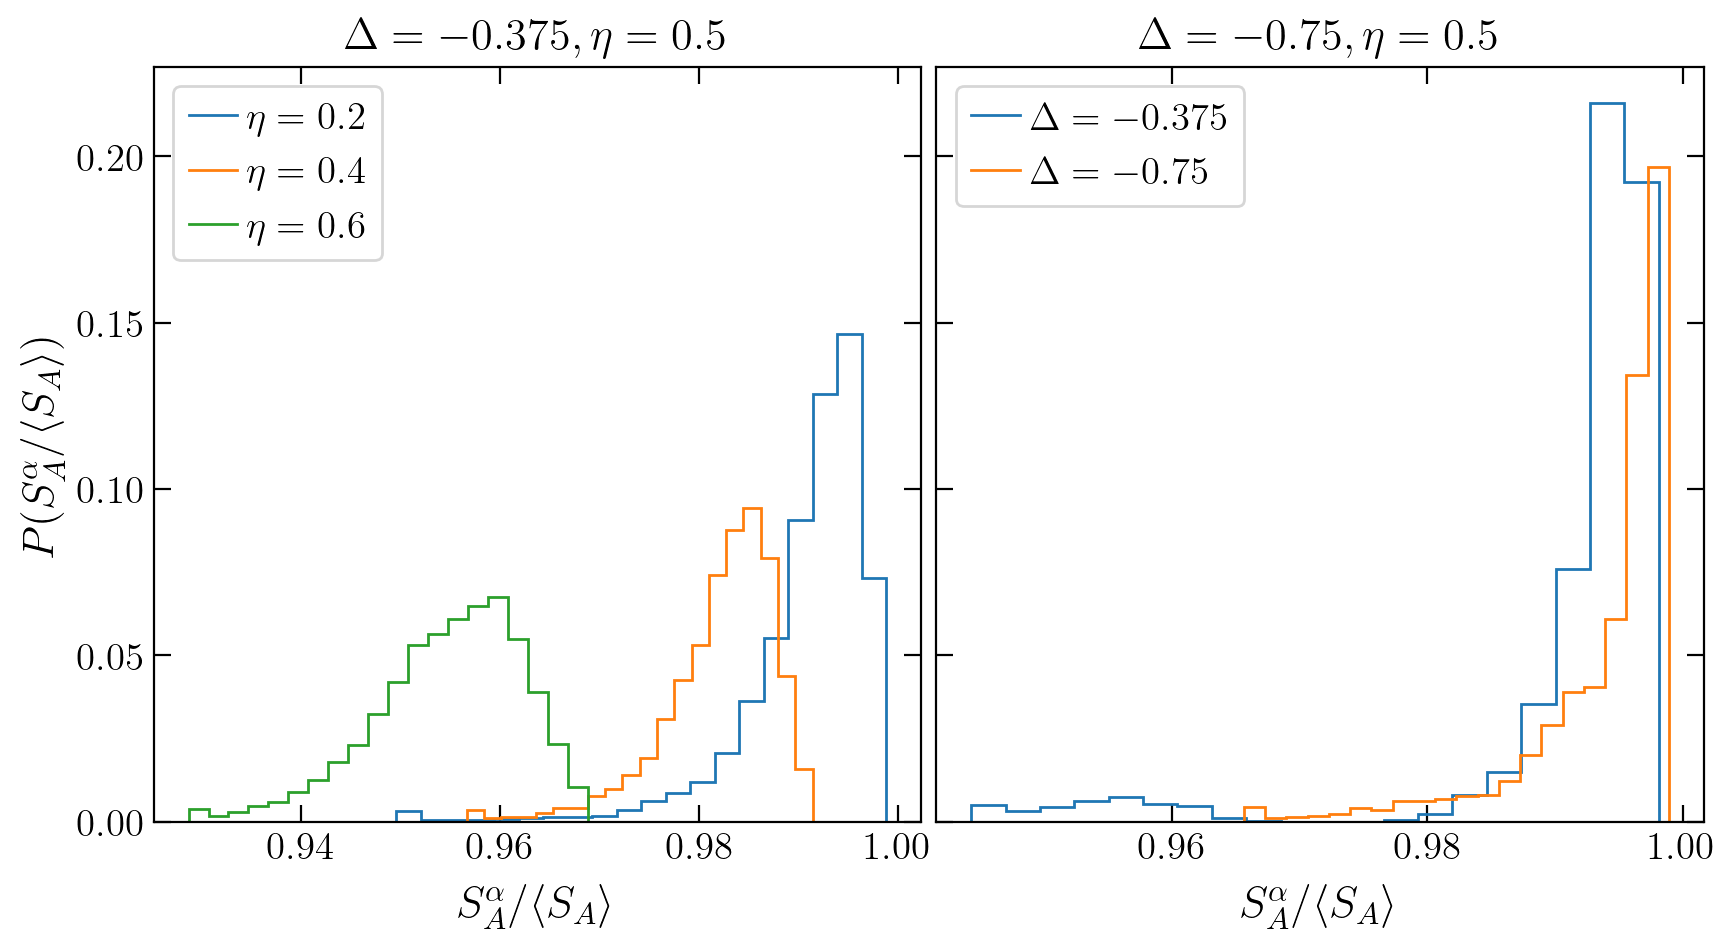

In [8]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

L=22

J1=1.0
d1=0.2
e1=0.2
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1


frac = lambda dim: 200#dim + 1


fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

dim_tot = 2**L
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)

nbins = 20

bins = np.linspace(0.35, 0.9, nbins+1)

def plottt(axis, d1, e1, label = "", criterion=lambda x: x == 1):
    col = next(colors_ls_cyc)
    sizes = sizes_even
    entropy= np.zeros((sizes.size))
    
    LAA = np.ones((sizes.size)).astype(int)
    LAA = sizes // 2
    #for ii, L in [L]:
    
    real_sec, imag_sec = get_sectors(L, hx, hz)

    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
    num_of_sectors = len(real_sec) + 2* len(imag_sec)

    LA = 2#L // 2
    dim_tot = 0
    
    entropy_dist = np.zeros((nbins))
    entropy_bins = np.zeros((nbins+1))
    for [ks, ps, zxs, zzs] in sects:
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])

                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                non_deg_idx = [idx for ii, idx in enumerate(indices) if criterion(counts[ii])]

                entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                
                dim = energies.size
                num = frac(dim)
                dim_tot += num if ks == 0 or ks == L / 2 else 2 * num


                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2) 
                if my_max >= dim: my_max = dim

                sample = entropies
                if num < dim and my_min > 0 and my_max < dim:
                    sample = entropies[my_min : my_max]
                
                hist, bins = np.histogram(sample / page_result(LA, L-LA), bins = nbins)

                entropy_dist += hist# * (dim if ks == 0 or ks == L / 2 else 2 * dim)
                
        else:
            print(name)
    if dim_tot != 2**L:
        print("waaaaaaa", dim_tot, 2**L)
      

    entropy_dist /= dim_tot
            
    axis.stairs(entropy_dist, bins, label=label)

plottt(axis[0], d1=0.2, e1=0.2, label=r"$\eta=0.2$")
plottt(axis[0], d1=0.2, e1=0.4, label=r"$\eta=0.4$")
plottt(axis[0], d1=0.2, e1=0.6, label=r"$\eta=0.6$")

colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[1], d1=-0.375, e1=0.5, label=r"$\Delta=-0.375$")
plottt(axis[1], d1=-0.75, e1=0.5, label=r"$\Delta=-0.75$")

axis[0].set_title(f"$\Delta={-0.375},\eta={0.5}$", fontsize=16)
axis[1].set_title(f"$\Delta={-0.75},\eta={0.5}$", fontsize=16)

fig_help.set_plot_elements(axis[0], ylabel=r"$P(S_A^\alpha / \langle S_A\rangle)$", xlabel=r"$S_A^\alpha / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[0].legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title_fontsize=16)

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$S_A^\alpha / \langle S_A\rangle$", font_size=14, set_legend=False)
axis[1].legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title_fontsize=16)

fig.subplots_adjust(wspace = 0.02, hspace=0.3)

# SUPERSYMMETRY

In [46]:
from sympy import init_session 
init_session()

IPython console for SymPy 1.9 (Python 3.9.7-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.9/



In [59]:
from sympy import Matrix, var
from sympy.physics.quantum import TensorProduct as tens
from sympy.physics.quantum.dagger import Dagger as dag
from sympy import Symbol, simplify, exp, log, pi
from sympy import I

eta = Symbol('eta', real=True)
lam = Symbol('lambda', real=True)
a = Symbol('a', real=True)
b = Symbol('b', real=True)

x1 = Symbol('x1', real=True)
x2 = Symbol('x2', real=True)
x3 = Symbol('x3', real=True)
x4 = Symbol('x4', real=True)

q1 = Matrix([[0, 1], [0, 0], [0, 0], [0, eta]])
q2 = Matrix([[eta, 0], [0, 0], [0, 0], [1, 0]])

e = Matrix([[1, 0], [0, 1]])

sigx = Matrix([[0, 1], [1, 0]])
sigy = Matrix([[0, -I], [I, 0]])
sigz = Matrix([[1, 0], [0, -1]])


up = Matrix([1, 0])
down = Matrix([0, 1])


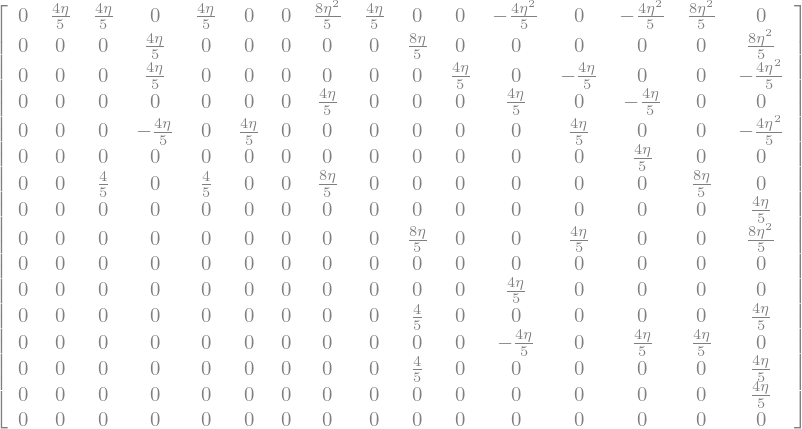

In [228]:
L=4

def make_matrix(L, pos, q):
    """
    Makes local supercharge 2^L+1 x 2^L at position pos
    """
    M = e if pos > 0 else q
    for indexi in range(1, L):
        M = tens(M, e) if indexi != pos else tens(M, q)
    return M

CN = zeros(2**(L), 2**L)

for ii in range(L):
    for jj in range(L):
        Q2 = make_matrix(L, ii, q2)
        Q1 = make_matrix(L, jj, q1)
        CN = CN + (-1)**(ii + jj) * dag(Q2) * Q1
CN = CN * L / (L+1)
#CN = CN + dag(CN)
#CN = CN.subs({eta: 0.5})
# a = CN.eigenvals()
# list(a)
# for xx in a:
#     print(xx)
CN

In [33]:
def make_product(L, op):
    M = op
    for indexi in range(1, L): 
        M = tens(M, op)
    return M
def make_Q(L):
    Q = make_matrix(L, 0, q1)
    for ii in range(1, L):
        M = make_matrix(L, ii, q1)
        Q = Q + (-1)**(ii) * M



In [ ]:
Px = make_product(L, sigx)
Py = make_product(L, sigy)
Pz = make_product(L, sigz)

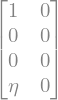

In [215]:
x = tens(sigz, sigz) * q2 * sigz


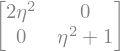

In [521]:
def ham_density(q):
    A = -tens(dag(q), e) * tens(e, q) - tens(e, dag(q)) * tens(q, e)
    return A + q * dag(q) + 0.5 * ( tens(dag(q) * q, e) + tens(e, dag(q) * q) )

q_obc = q1 + Matrix([[2*x1, 0], [x2, x1], [x2, x1], [0, 2*x2]])

q_obc = q_obc.subs({x2: -eta})
q_obc = q_obc.subs({x1: 0})
dag(q_obc) * q_obc

# x = (tens(q_obc, e) * q_obc - tens(e, q_obc) * q_obc)


# m = Matrix([a, b])

# bound = dag(q_obc) * q_obc / 2
# #x * m
# #ham_density(q_obc).subs({lam: eta})

# bound = -(1-eta)*x1 / (1+(x1**2 + x2*2)) * sigx - (1+eta)*x2 / (1+(x1**2 + x2*2)) * sigy + (eta**2-1)/4*( (1-(x1**2 + x2*2)) / (1+(x1**2 + x2*2)) ) * sigz
# bound = (bound.subs({x1 : 0})).subs({x2: 1})
# sigy * bound * sigy - bound

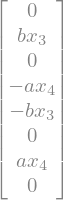

In [439]:

chi = Matrix([x3, 0, 0, x4])
tens(chi, m) - tens(m, chi)

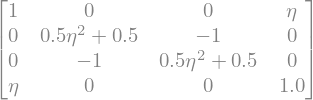

In [522]:

h2 = ham_density(q_obc)
h2

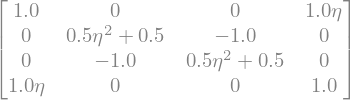

In [523]:
h = (1 - eta) * tens(sigx, sigx) + (1 + eta) * tens(sigy, sigy) + (eta**2 - 1) / 2 * tens(sigz, sigz)
h = (3 + eta**2) / 4 * tens(e,e) - 0.5*h
h

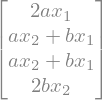

In [517]:
q_obc = q1 + Matrix([[2*x1, 0], [x2, x1], [x2, x1], [0, 2*x2]])
dag(q_obc)
q_obc

m = Matrix([a, b])
chi = Matrix([x1, x2])

tens(m, chi) + tens(chi, m)

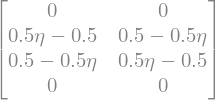

In [37]:
singlet = 1/np.sqrt(2) * Matrix([[1, -1], [-1, 1]])

SS = tens(singlet, e) - tens(e, singlet)

SS * q1 * singlet

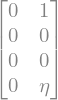

In [17]:
A = -tens(dag(q1), e) * tens(e, q1) - tens(e, dag(q1)) * tens(q1, e)
q1

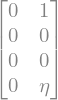

In [16]:
B = tens(up,  (sigx + sigy*I)) / 2 + eta * tens(down, (e - sigz)) / 2
B

In [48]:
Jx = Symbol('Jx', real=True)
Jy = Symbol('Jy', real=True)
Jz = Symbol('Jz', real=True)
hx = Symbol('hx', real=True)
hz = Symbol('hz', real=True)

q = Symbol('q', real=False)

x1 = Symbol('x1', real=True)
x2 = Symbol('x2', real=True)
x3 = Symbol('x3', real=True)
x4 = Symbol('x4', real=True)
x5 = Symbol('x5', real=True)
x6 = Symbol('x6', real=True)
x7 = Symbol('x7', real=True)
x8 = Symbol('x8', real=True)
x9 = Symbol('x9', real=True)

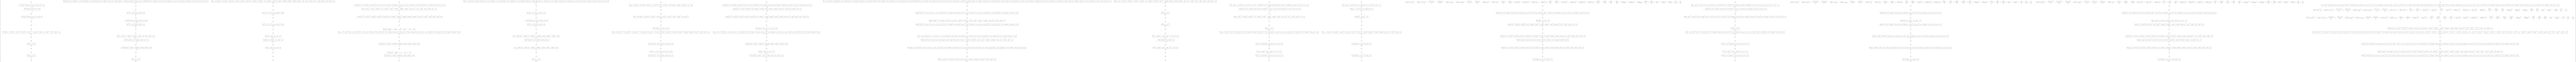

In [71]:
L=4
H = Matrix.zeros(2**L, 2**L)
X = Matrix.zeros(2**L, 2**L)

def expand_op(L, op, j):
    A = op if j == 1 else e
    for ii in range(2, L + 1):
        A = tens(A, op) if ii == j else tens(A, e)
    return A

Px = Matrix.eye(2**L, 2**L)
Py = Matrix.eye(2**L, 2**L)
Pz = Matrix.eye(2**L, 2**L)
P = Matrix.eye(2**L, 2**L)

op1 = Matrix([[q, 0], [0, 1/q]])
op2 = Matrix([[1/q, 0], [0, q]])

Xp = X
Xm = X

sig_p = sigx + I * sigy
sig_m = sigx - I * sigy
Xploc = sig_p
Xmloc = sig_m
for jj in range(2, L + 1):
    Xploc = tens(Xploc, op2)
    Xmloc = tens(Xmloc, op2)
    
Xp += Xploc
Xm += Xmloc

for ii in range(1, L + 1):
    #if ii < L:
    nei = ii + 1
    H += (1-eta) * expand_op(L, sigx, ii) * expand_op(L, sigx, nei if nei <= L else 1) / 2
    H += (1+eta) * expand_op(L, sigy, ii) * expand_op(L, sigy, nei if nei <= L else 1) / 2
    H += Jz * expand_op(L, sigz, ii) * expand_op(L, sigz, nei if nei <= L else 1) / 2
    
    Xploc = op1
    Xmloc = op1
    if ii > 1:
        for jj in range(2, L + 1):
            Xploc = tens(Xploc, op1) if jj < ii else (tens(Xploc, sig_p) if jj == ii else tens(Xploc, op2))
            Xmloc = tens(Xmloc, op1) if jj < ii else (tens(Xmloc, sig_p) if jj == ii else tens(Xmloc, op2))
            
        Xp += Xploc
        Xm += Xmloc
    # H += hx * expand_op(L, sigx, ii)
    # H += hz * expand_op(L, sigz, ii)
    # if ii % 2 == 0:
    #     Px = Px * expand_op(L, sigx + I*sigy, ii)
    #     Py = Py * expand_op(L, sigx - I*sigy, ii)
    #     #Pz = Pz * expand_op(L, sigz, ii)
    # else:
    # #     Px = Px * expand_op(L, sigz, ii)
    # #     Py = Py * expand_op(L, sigx, ii)
    #      Pz = Pz * expand_op(L, sigy, ii)

# P = (Jz * Px + Jz * Py + Jz*(Jx + Jy)*Pz)
# P * H - H * P
#tens(tens(sigx, e), e)
#expand_op(L, sigz, 2)

X = (Xp + eta * Xm)**3

simplify(X * H - H * X)#.subs({q: exp(2 * pi/3*I)}).subs({eta: 0})#.subs({Jz: (q + 1)/2})





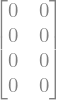

In [45]:
x1 = Symbol('x1', real = True)
x2 = Symbol('x2')

x3 = Symbol('x3', real=True)
x4 = Symbol('x4')
U = Matrix([[x1, x2], [dag(x2), x3]])

(tens(sigz, sigz) * q1 * sigz + q1)